<a href="https://colab.research.google.com/github/delffine/Pet-projects/blob/main/bike_train_duration/veloopros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Вводная часть

Это исследование взаимосвязи функциональной мощности и длительности тренировок велосипедистов и триатлетов. Анализ проведен по данным опроса спортсменов, который проводился в телеграмм-канале [Тренер Сурен](https://t.me/surencoach/1082) основателя онлайн-платформы для подготовки к стартам по триатлону и велоспорту Trisystems Сурена Арутюняна. Всего в опросе приняло участие более 300 спортсменов. Требовалось обнаружить и описать взаимосвязи объема тренировок с мощностью, а также возможные связи с другими параметрами тренировок и спортсменов.

Данные формы опроса проходят ручную предобработку. Явные аномалии, где это возможно, корректируются. Ответы с пустыми ключевыми для исследования колонками - удаляются. Данные для расчета экспортируются в неудобном для анализа формате, поэтому требуется предобработка данных.

Ход исследования:
- Загрузка данных
- Предобработка данных
- Исследовательский анализ данных
- Определение корреляции числовых показателей
- Определение взаимосвязи FTP и веломинут
- Когортный анализ данных по FTP, веломинутам и стажу
- Изучение аномалий взаимосвязи роста FTP с ростом веломинут
- Сравнение тренировок велосипедистов и триатлетов
- Сравнение способов определения FTP

*Здесь и далее, если речь идет о только о велотренировках, то используется термин "веломинуты"*


# Процедуры и функции

В этом разделе размещены используемые в анализе процедуры и функции

In [367]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import math
import numpy as np
import scipy.stats as stats
from matplotlib.colors import TwoSlopeNorm
from matplotlib import colors
from matplotlib import colormaps

In [368]:
pd.options.display.max_colwidth = 9000

In [369]:
#Цвет RGB в HEX
def rgba2hex(rgba):
    r = int(rgba[0] * 255)
    g = int(rgba[1] * 255)
    b = int(rgba[2] * 255)
    return f'#{r:02x}{g:02x}{b:02x}'


In [370]:
#Список градиентов цвета в зависимости от входной величины
def gradient_by_value(col = pd.Series([]), gradient = plt.cm.RdYlGn_r):
    norm = TwoSlopeNorm(vmin=col.min(), vcenter=col.mean(), vmax=col.max())
    colors = [rgba2hex(gradient(norm(c))) for c in col]
    return colors

In [371]:
# Вывод проверки выброк для тестирования
def chek_dd_test(d_test1, d_test2):
  norm1 = False
  norm2 = False
  pval = stats.normaltest(d_test1)[1]
  if pval < 0.05:
     print(f'Первая выборка размером {len(d_test1)} НЕ прошла проверку на нормальное распределение. pval = {pval}')
  else:
      print(f'Первая выборка размером {len(d_test1)} прошла проверку на нормальное распределение. pval = {pval}')
      norm1 = True

  pval = stats.normaltest(d_test2)[1]
  if pval < 0.05:
      print(f'Вторая выборка размером {len(d_test2)} НЕ прошла проверку на нормальное распределение. pval = {pval}')
  else:
      print(f'Вторая выборка размером {len(d_test2)} прошла проверку на нормальное распределение. pval = {pval}')
      norm2 = True

  equal_var = False
  pval = stats.levene(d_test1, d_test2)[1]
  if pval < 0.05:
      print(f'Дисперсии выборок НЕ близки. pval = {pval}. Применяем equal_var=False')
  else:
      print(f'Дисперсии выборок близки. pval = {pval}. Применяем equal_var=True ')
      equal_var = True
  return norm1, norm2, equal_var

In [372]:
# Вывод результатов тестирования в зависимост от pvalue
def pval_print (pval, h0='', h1=''):
    print('В результате теста получено p-value', pval)
    if pval < 0.05:
        print('НЕ можем принять нулевую гипотезу, принимаем альтернативную:')
        print(' ------> \033[31m\033[1m', h1, '\033[0m')
    else:
        print('НЕ можем отвегнуть нулевую гипотезу, принимаем ее:')
        print(' ------> \033[32m\033[1m', h0, '\033[0m')

In [373]:
# Тестирование сравнения двух выборок
def test_selection (d_test1, d_test2, side='two-sided', h0='', h1=''):
  norm1, norm2, e_var = chek_dd_test(d_test1, d_test2)
  l1 = (len(d_test1) >= 30)
  l2 = (len(d_test2) >= 30)
  print()
  if (norm1 & norm2): print('Обе выборки имеют нормальное распределение!')
  if ((l1 or norm1) and (l2 or norm2)) :
    if (l1 & l2): print(f'Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest')
    print()
    print('--- Проводим TTest ---')
    pval = stats.ttest_ind(d_test1, d_test2, alternative = side, equal_var=e_var)[1]
    pval_print(pval, h0, h1)
    print()
    print('Для сравнения проведем и параметрический тест Манна-Уитни')
    print()
  else:
    print(f'Выборки маленькие ({len(d_test1)} / {len(d_test2)}) - НЕЛЬЗЯ применять ttest')

  print('---- Проводим Test Mann-Whitneyu ----')
  pval = stats.mannwhitneyu(d_test1, d_test2, alternative = side)[1]
  pval_print(pval, h0, h1)

In [374]:
# Z-критерий проверки равенства пропорций
# Из курса Яндекс.Практиум
# С доработкой односторонних гипотез
# проверят a1/a2 <=> n1/n2
def z_krit(a1, a2, n1, n2, alt = 'two'):
    #alt - ‘two’, ‘smaller’, ‘larger’
    p1 = a1 / n1
    p2 = a2 / n2
    p_combined = (a1 + a2) / (n1 + n2)
    difference = p1-p2
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))
    distr = stats.norm(0,1)
#    p_value = (1 - distr.cdf(abs(z_value))) * 2
    if alt == 'two':   p_value = (1 - distr.cdf(abs(z_value))) * 2
    if alt == 'larger':   p_value = (1 - distr.cdf(z_value)) * 2
    if alt == 'smaller':   p_value = (1 - distr.cdf(-z_value)) * 2

    if p_value > 1: p_value = 1

    return p_value

In [375]:
#подсветка ячеек, значения которых меньше 0.05
def highlight_stat(s, color='orange', p = 0.05):
    return ['background-color: '+color if val < p  else 'background-color: none' for val in s]

In [376]:
#подсветка ячеек, значения которых меньше 0.05
def highlight_over(s, color='lime', p = 0.5):
      return ['background-color: '+color if val > p else 'background-color: none' for val in s]

In [377]:
def background_gradient_alltable(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    #c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [colors.rgb2hex(x) for x in colormaps[cmap](normed)]
    return ['background-color: %s' % color for color in c]

# Загрузка данных

In [378]:
#Данные для аналза хранятся в excel файле на google.disc
#Подлючаем google.disc как папку
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/dtp/'):
  from google.colab import drive
  drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/bike_duration/

/content/drive/My Drive/Colab Notebooks/bike_duration


In [379]:
#загрузка данных
data = pd.read_excel('bike_train_duration.xlsx')

In [380]:
#просмотр загруженных данны
data.head()

,Timestamp,Ваш вес,Ваш пол,Ваш вид спорта,"Какой у вас средний тренировочный объем велотренировок в неделю в часах за последний год (укажите, пожалуйста, в формате чч:мм:сс)","Если знаете, то укажите какой у вас средний тренировочный объем в неделю в часах за последний год по другим активности вместе взятым (силовые, бег, плавание и тд, в формате чч:мм:сс)",Сколько месяцев или лет (уточните в ответе) у вас общий тренировочный стаж в тренировках по велосипеду? Если был значительный перерыв в тренировках также напишите про это.,"Какой у вас наивысший уровень анаэробного порога (часовой мощности или ФТП) в этом сезоне? Укажите цифру по мощности (например, 210)",Каким способом вы определили ваш пиковый анаэробный порог (ФТП) в сезоне?,Стаж ручное редактировние
0,2024-12-26 12:58:01.835,73.0,Мужской,Триатлон,6:00:00,11:00:00,4 года,285,По результатом полевых тестирований,48
1,2024-12-26 12:59:07.121,73.0,Мужской,Велоспорт,13:16:25,NaN,4,320,Расчетным путем исходя их результатов гонок,48
2,2024-12-26 13:00:24.132,73.0,Мужской,Триатлон,05:43:57,10:49:50,5 лет,215,Из результатов лабораторного тестирования,60
3,2024-12-26 13:00:38.202,82.0,Мужской,Триатлон,4:30:00,8:30:00,2года,215,Seift,24
4,2024-12-26 13:01:04.913,77.0,Мужской,Трейл,00:44:29,NaN,"Где то с прошлого лета крутил когда купил вело тренажер , кручу переиодически не постоянно",257,По результатом полевых тестирований,18


In [381]:
#Переименовываем колонки
data.columns = ('date_answer' , 'weigth', 'gender', 'sport', 'bike_hours', 'train_hours', 'train_stag', 'ftp', 'ftp_source', 'stag_r')

In [382]:
#Общая информация о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date_answer  295 non-null    datetime64[ns]
 1   weigth       295 non-null    float64       
 2   gender       295 non-null    object        
 3   sport        295 non-null    object        
 4   bike_hours   295 non-null    object        
 5   train_hours  217 non-null    object        
 6   train_stag   295 non-null    object        
 7   ftp          295 non-null    int64         
 8   ftp_source   295 non-null    object        
 9   stag_r       295 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 23.2+ KB


In [383]:
#Количество строк в исходном датасете
data_l0 = len(data)
print(f"Количество строк в исходном датасете {data_l0}")

Количество строк в исходном датасете 295


# Предобработка данных

In [384]:
#проверка на дубликаты
data[data.duplicated()]

,date_answer,weigth,gender,sport,bike_hours,train_hours,train_stag,ftp,ftp_source,stag_r


In [385]:
#проверка на пропуски
(round(data.isna().sum() / data_l0, 2)).reset_index().T

,0,1,2,3,4,5,6,7,8,9
index,date_answer,weigth,gender,sport,bike_hours,train_hours,train_stag,ftp,ftp_source,stag_r
0,0.0,0.0,0.0,0.0,0.0,0.26,0.0,0.0,0.0,0.0


Преобразуем исходные данные к удобоваримому виду

In [386]:
for i in range(0, len(data)):
# ------------- велотренировки ---------------------------
    bh = str(data.loc[i, 'bike_hours'])
    if bh != bh: bh = '0'
    bh = bh.replace(',', '.')
    bh = bh.replace('-', ':')
    bh = re.sub(r'[^0-9.:]+', '', bh)
    digits = []
    digits.append(re.split(':', bh))
    try:
        minuts = float(digits[-1][0]) * 60 + float(digits[-1][1])
    except:
        try:
            minuts = float(digits[-1][0]) * 60
        except:
            minuts = 0
    data.loc[i, 'bike_minute'] = minuts

# -------------- остальные тренировки -----------------------------
    th = str(data.loc[i, 'train_hours'])
    if th != th: th = '0'
    th = th.replace(',', '.')
    th = th.replace('-', ':')
    th = re.sub(r'[^0-9.:]+', '', th)
    digits = []
    digits.append(re.split(':', th))
    try:
        minuts = float(digits[-1][0]) * 60 + float(digits[-1][1])
    except:
        try:
            minuts = float(digits[-1][0]) * 60
        except:
            minuts = 0
    data.loc[i, 'train_minute'] = minuts

# ------------ Стаж. Каша в данных ---------------------
#    st = str(data.loc[i, 'train_stag'])
#    if st != st: st = '0'
#
#    st = re.sub(r'[^0-9.:]+', '', st)
#    try:
#        stag = float(st)
#    except:
#        stag = 0
#    data.loc[i, 'stag_c'] = stag
#
# ------------ вес ----------------------------------
    wg = str(data.loc[i, 'weigth'])
    if wg != wg: wg = '0'
    wg = wg.replace(',', '.')
    wg = re.sub(r'[^0-9.:]+', '', wg)
    try:
        weigth = float(wg)
    except:
        weigth = 0
    data.loc[i, 'weigth_c'] = weigth


# ----------- FTP  ---------------------------------
    ftp = str(data.loc[i, 'ftp'])
    if ftp != ftp: ftp = '0'

    ftp = re.sub(r'[^0-9.:]+', '', ftp)
    try:
        ftpf = float(ftp)
    except:
        ftpf = 0
    data.loc[i, 'ftp_c'] = ftpf


Проверяем аномалии по колонкам

In [387]:
#аномальный вес
data.query('weigth_c < 50 | weigth_c > 150')

,date_answer,weigth,gender,sport,bike_hours,train_hours,train_stag,ftp,ftp_source,stag_r,bike_minute,train_minute,weigth_c,ftp_c


In [388]:
#аномальный FTP
data.query('ftp_c < 100 | ftp_c > 500')[['date_answer', 'gender', 'sport', 'ftp', 'ftp_c']]

,date_answer,gender,sport,ftp,ftp_c


In [389]:
#аномальные веломинуты
data.query('bike_minute < 30 | bike_minute > 1000')[['date_answer', 'gender', 'sport', 'bike_hours', 'bike_minute', 'ftp_c']]

,date_answer,gender,sport,bike_hours,bike_minute,ftp_c
154,2024-12-28 08:52:36.671,Мужской,Велоспорт,19:54:06,1194.0,323.0
187,2024-12-29 08:58:49.609,Мужской,"Бег, лыжи",00:25:29,25.0,260.0
232,2024-12-29 11:37:34.693,Мужской,Триатлон,17:45:00,1065.0,360.0


In [390]:
#аномальная длительность других тренировок
data.query('(train_minute > 0 & train_minute < 30) | train_minute > 1000')[['date_answer', 'gender', 'sport', 'train_hours', 'train_minute']]

,date_answer,gender,sport,train_hours,train_minute
123,2024-12-26 22:08:12.788,Мужской,Велоспорт,00:13:30,13.0
138,2024-12-27 09:14:37.500,Мужской,Велоспорт,00:15:00,15.0


**Все выявленные тут аномалии правятся вручную в файле данных на гугл диске !!!!**

In [391]:
#Переназначаем индексы после предобработки
data = data.reset_index(drop = True)

In [392]:
print(f'После предобработки осталось данные по {len(data)} спортсменам. Изначально было {data_l0}')

После предобработки осталось данные по 295 спортсменам. Изначально было 295


In [393]:
#Расчет FTP в ватт/кг
data['ftp_weigth'] = data['ftp_c'] / data['weigth_c']

**Промежуточные итоги**

Предобработка исходных данных включала:
Очистку числовых данных от буквенных символов и перевод веломинут и длительности остальных тренировок, указанные в основном в формате ЧЧ:ММ:СС, в минуты.
После программного преобразования выполнена проверка на аномалии и вручную исправлено несколько некорректных значений. Удалено три строчки.

# Исследовательский анализ данных

## Категориальные данные

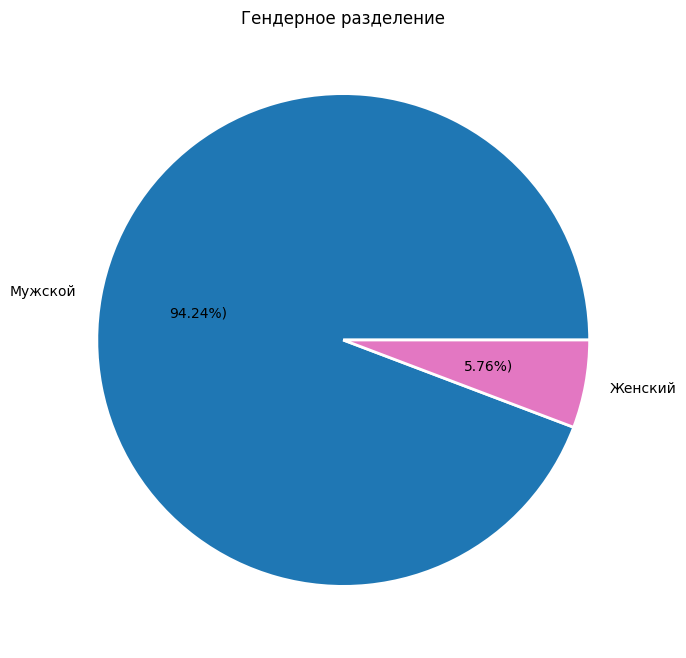

In [394]:
dd = data['gender'].value_counts()

fig = plt.figure(figsize = (15, 8))
plt.pie(x = dd, labels = dd.index, colors = ['tab:blue', 'tab:pink', 'yellow'],
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
plt.title('Гендерное разделение')
plt.show()

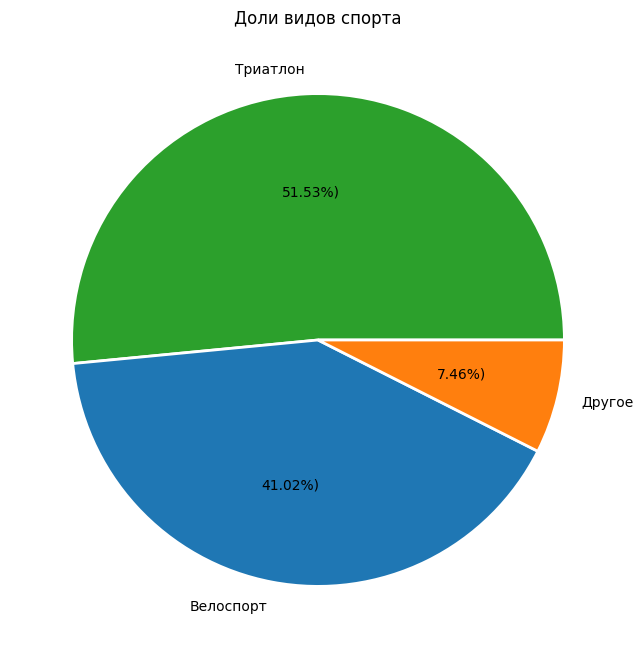

In [395]:
data['sport_c'] = data['sport'].apply(lambda x: 'Другое' if x not in ('Триатлон', 'Велоспорт') else x)

dd = data['sport_c'].value_counts()

fig = plt.figure(figsize = (15, 8))
plt.pie(x = dd, labels = dd.index, colors = ['tab:green', 'tab:blue', 'tab:orange'],
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
plt.title('Доли видов спорта')
plt.show()



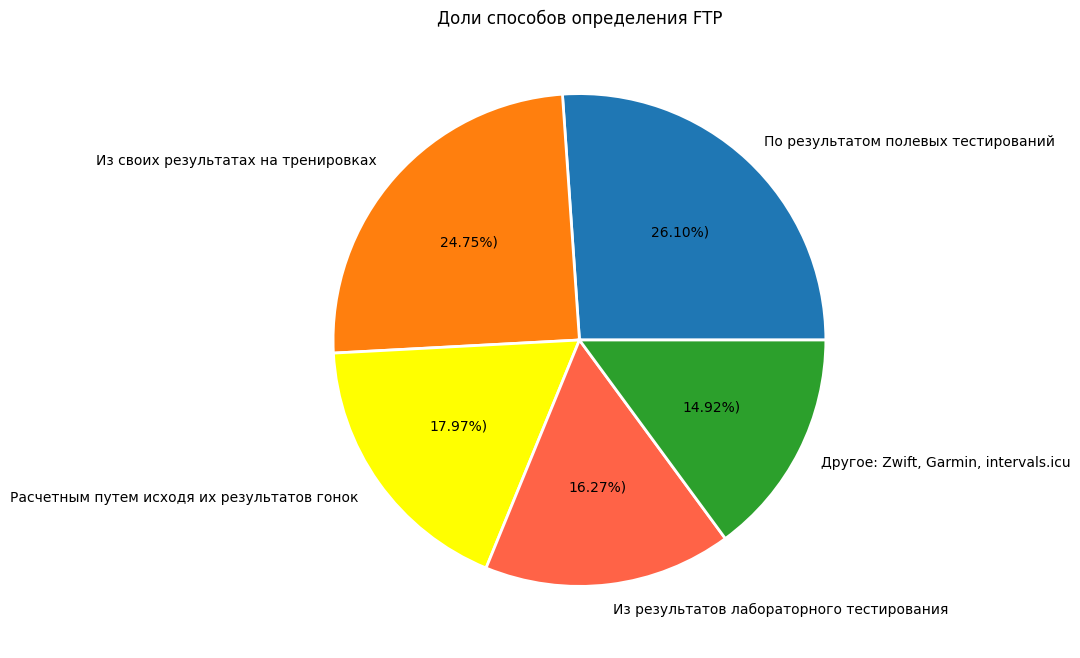

In [396]:
data['ftp_source_c'] = data['ftp_source'].apply(lambda x: 'Другое: Zwift, Garmin, intervals.icu' if x not in (
    'По результатом полевых тестирований',
    'Из своих результатах на тренировках',
    'Расчетным путем исходя их результатов гонок',
    'Из результатов лабораторного тестирования',
    ) else x)

fig = plt.figure(figsize = (15, 8))
plt.pie(x = data['ftp_source_c'].value_counts(), labels = data['ftp_source_c'].value_counts().index, colors = ['tab:blue', 'tab:orange', 'yellow', 'tomato', 'tab:green'],
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
plt.title('Доли способов определения FTP')
plt.show()

Стаж можно также считать категориальной функцией

## Статистические харакретистики числовых показателей

In [397]:
train_stat = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
train_stat.loc['Веломинуты'] = data['bike_minute'].describe()
train_stat.loc['Другие тренировки'] = data['train_minute'].describe()
train_stat.loc['FTP'] = data['ftp_c'].describe()
train_stat.loc['Вес'] = data['weigth_c'].describe()
train_stat.loc['Стаж'] = data['stag_r'].describe()
train_stat

,count,mean,std,min,25%,50%,75%,max
Веломинуты,295.0,322.837966,194.092154,25.0,180.0,274.0,420.0,1194.0
Другие тренировки,295.0,243.010169,230.700700,0.0,0.0,210.0,403.0,900.0
FTP,295.0,258.752542,46.663761,139.0,225.0,256.0,290.0,402.0
Вес,295.0,75.555254,10.299410,52.0,70.0,75.0,80.5,122.0
Стаж,295.0,52.640678,44.693282,2.0,24.0,40.0,60.0,360.0


Расшифровка
- count - количество спортсменов, по которому расчитаны характеристики
- mean - среднее
- std - стандартное отклонение
- min - минимальное значение
- 25% - первый квантиль - граница 25% значений
- 50% - медиана
- 75% - третий квантиль - граница 75% значений
- max - максимальное значение

Читается так: среднее значение FTP - 258, медианное - 256, минимальное - 139, максимальное - 402. "Серединная" половина спортсменов (от 25% до 75%) имеет FTP от 225 до 290 ватт - такая широкая "золотая середина".

Кстати, большая разница между средним значением и медианой говорит о выбросах. Если среднее больше медианы, то выбросы в большую сторону

Те же статистические характеристики в виде графиков.

Закрашенная область - серединная половина, широкая "золотая середина". Толстая  черта в этой области - медиана. Кстати, она необязательно посередине закрашенной области. Верхний ус - граница в 97% спортсменов, нижний ус - 3%. Точки выше или ниже усов считаются "выбросами/аномалиями" и обычно из данных для дальнейшего анализа удаляются.

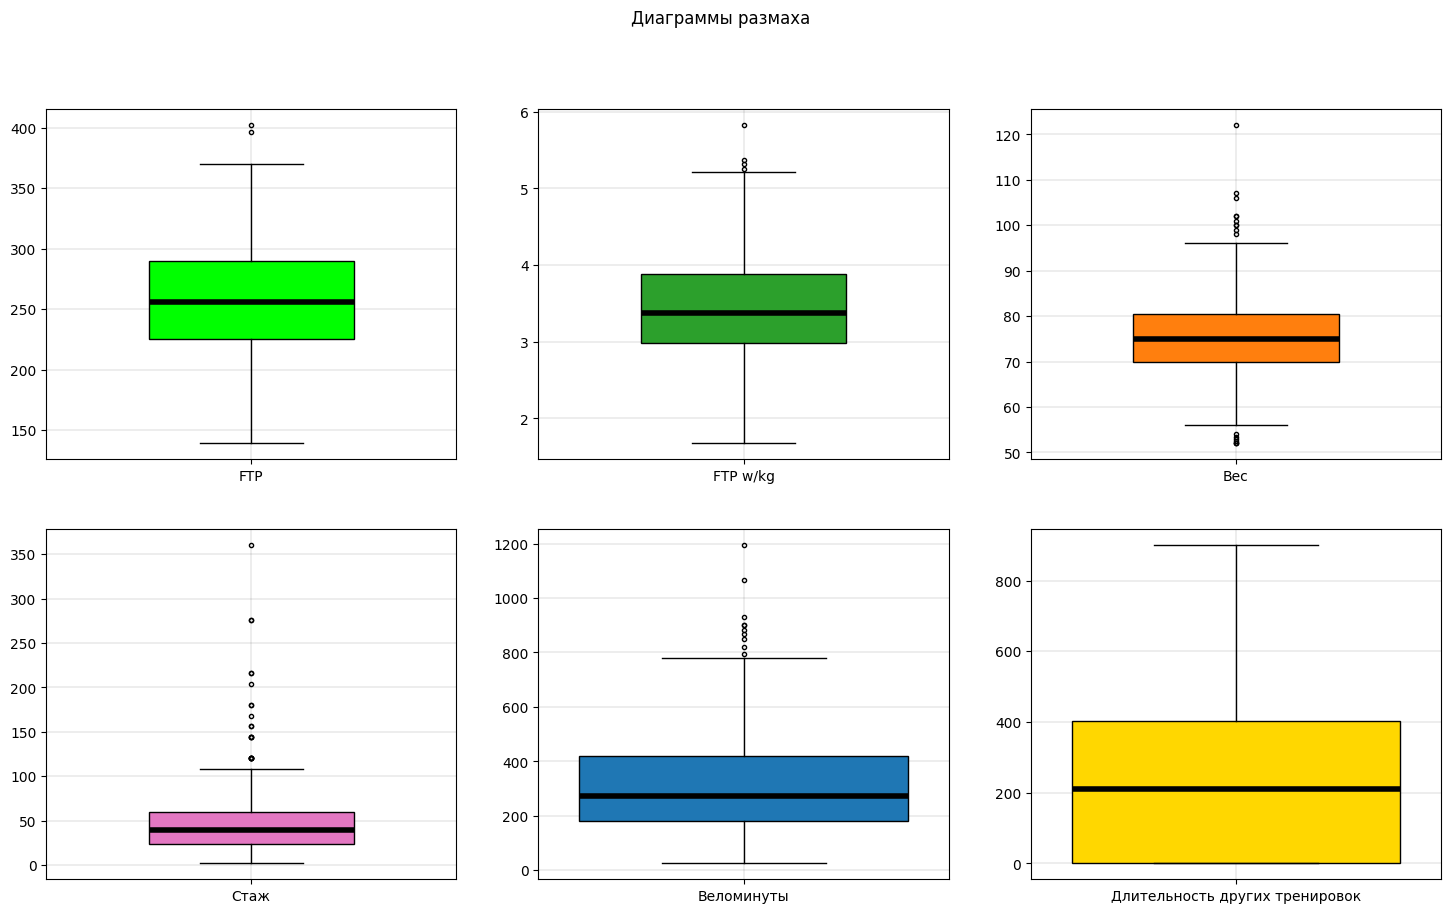

In [398]:
f, ax = plt.subplots(2, 3, figsize=(18,10))
ax[0, 0].boxplot(data['ftp_c'], positions=[2], labels = ['FTP'], widths = 0.5 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='lime'), medianprops=dict(color='black', linewidth=4))
ax[0, 0].grid(color='black', linestyle='-', linewidth=0.1)

ax[0, 1].boxplot(data['ftp_weigth'], positions=[2], labels = ['FTP w/kg'], widths = 0.5 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='tab:green'), medianprops=dict(color='black', linewidth=4))
ax[0, 1].grid(color='black', linestyle='-', linewidth=0.1)


ax[0, 2].boxplot(data['weigth_c'], positions=[2], labels = ['Вес'], widths = 0.5 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='tab:orange'), medianprops=dict(color='black', linewidth=4))

ax[0, 2].grid(color='black', linestyle='-', linewidth=0.1)

ax[1, 0].boxplot(data['stag_r'], positions=[2], labels = ['Стаж'], widths = 0.5 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='tab:pink'), medianprops=dict(color='black', linewidth=4))
ax[1, 0].grid(color='black', linestyle='-', linewidth=0.1)


ax[1, 1].boxplot(data['bike_minute'], positions=[0], labels = ['Веломинуты'], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='tab:blue'), medianprops=dict(color='black', linewidth=4))
ax[1, 1].grid(color='black', linestyle='-', linewidth=0.1)


ax[1, 2].boxplot(data['train_minute'], positions=[1], labels = ['Длительность других тренировок'], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='gold'), medianprops=dict(color='black', linewidth=4))
ax[1, 2].grid(color='black', linestyle='-', linewidth=0.1)


plt.suptitle('Диаграммы размаха')
plt.show()


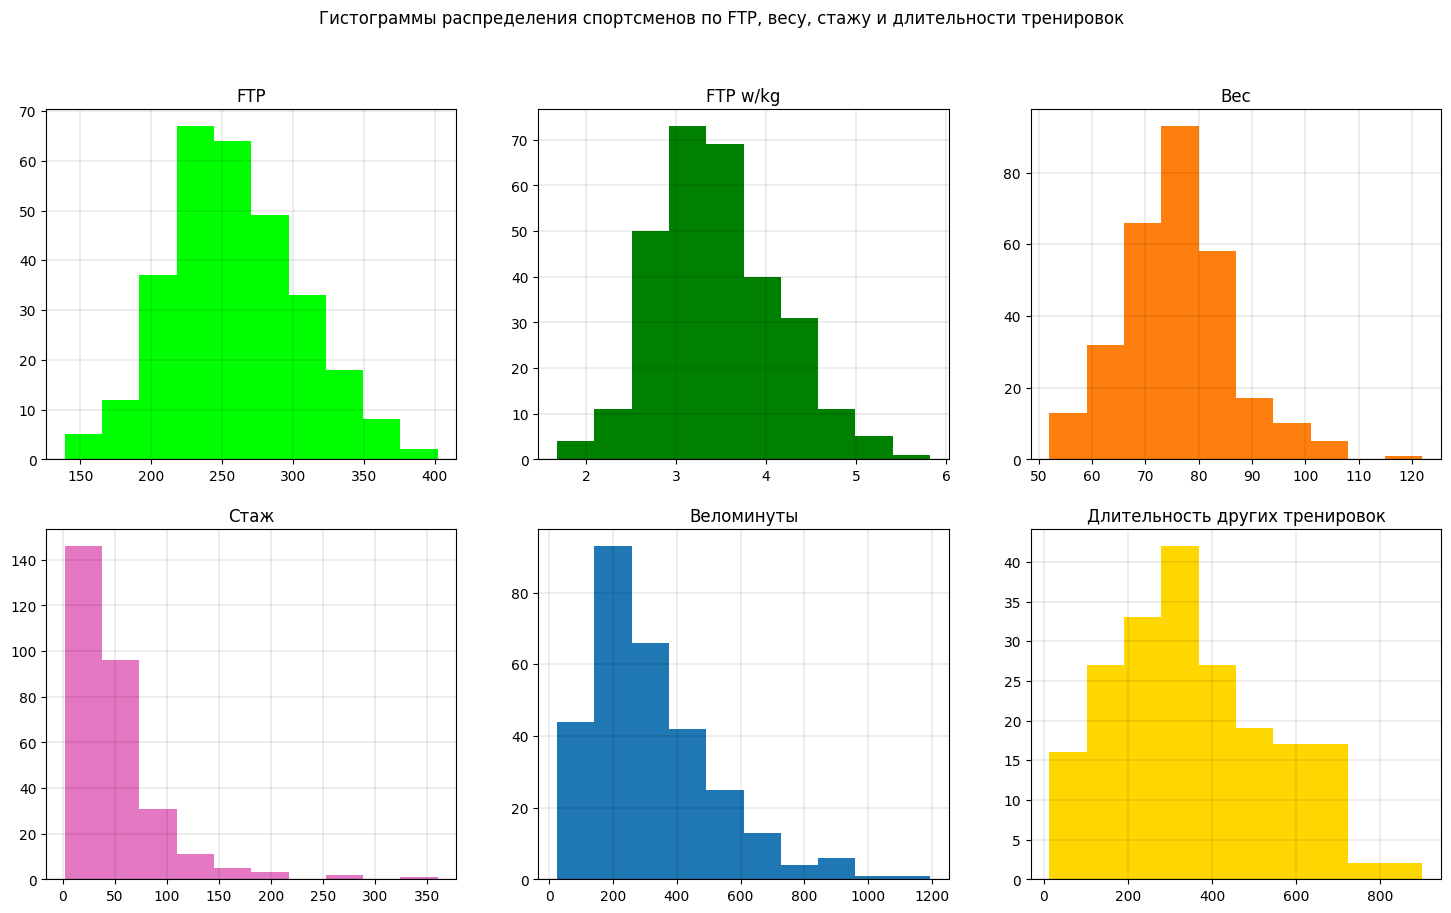

In [399]:
f, ax = plt.subplots(2, 3, figsize=(18,10))
ax[0, 0].hist(data['ftp_c'], bins = 10, alpha = 1, color = 'lime')
ax[0, 0].grid(color='black', linestyle='-', linewidth=0.1)
ax[0, 0].set_title('FTP')

ax[0, 1].hist(data['ftp_weigth'], bins = 10, alpha = 1, color = 'green')
ax[0, 1].grid(color='black', linestyle='-', linewidth=0.1)
ax[0, 1].set_title('FTP w/kg')


ax[0, 2].hist(data['weigth_c'], bins = 10, alpha = 1, color = 'tab:orange')
ax[0, 2].grid(color='black', linestyle='-', linewidth=0.1)
ax[0, 2].set_title('Вес')

ax[1, 0].hist(data['stag_r'], bins = 10, alpha = 1, color = 'tab:pink')
ax[1, 0].grid(color='black', linestyle='-', linewidth=0.1)
ax[1, 0].set_title('Стаж')

ax[1, 1].hist(data['bike_minute'], bins = 10, alpha = 1, color = 'tab:blue')
ax[1, 1].grid(color='black', linestyle='-', linewidth=0.1)
ax[1, 1].set_title('Веломинуты')

ax[1, 2].hist(data.query('train_minute > 0')['train_minute'], bins = 10, alpha = 1, color = 'gold')
ax[1, 2].grid(color='black', linestyle='-', linewidth=0.1)
ax[1, 2].set_title('Длительность других тренировок')


plt.suptitle('Гистограммы распределения спортсменов по FTP, весу, стажу и длительности тренировок')
plt.show()

Проверка нормального распределения по колонкам

In [400]:
norm_check = pd.DataFrame([])
for col in ['ftp_c', 'ftp_weigth', 'weigth', 'stag_r', 'bike_minute', 'train_minute']:
  norm_check.loc['norm', col] = stats.normaltest(data[col])[1]
  norm_check.loc['shapiro', col] = stats.shapiro(data[col])[1]
  norm_check.loc['kstest', col] = stats.kstest(data[col], 'norm')[1]
norm_check.style.apply(highlight_stat, color='tomato')

,ftp_c,ftp_weigth,weigth,stag_r,bike_minute,train_minute
norm,0.098774,0.004720,0.000002,0.000000,0.000000,0.000000
shapiro,0.078993,0.004169,0.000038,0.000000,0.000000,0.000000
kstest,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Только FTP проходит проверку на нормальное распределение.

## Аномалии и выбросы

Зададим верхнюю границу для аномальных значений в 97%

In [401]:
ftp_lim = int(data['ftp_c'].quantile(0.97))
bike_minute_lim = int(data['bike_minute'].quantile(0.97))
stag_minute_lim = int(data['stag_r'].quantile(0.97))

print(f'Верхняя граница нормальных значений FTP {ftp_lim}')
print(f'Верхняя граница нормальных значений веломинут {bike_minute_lim}')
print(f'Верхняя граница нормальных значений стажа {stag_minute_lim}')

Верхняя граница нормальных значений FTP 351
Верхняя граница нормальных значений веломинут 800
Верхняя граница нормальных значений стажа 158


Для дальнейшего анализа отбрасываем аномальные значения / выбросы

In [402]:
data = data.query('ftp_c <= @ftp_lim & stag_r <= @stag_minute_lim & bike_minute <= @bike_minute_lim')

In [403]:
data = data.reset_index(drop = True)

Статистический характеристики данных без выбросов

In [404]:
train_stat = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
train_stat.loc['Веломинуты'] = data['bike_minute'].describe()
train_stat.loc['Другие тренировки'] = data['train_minute'].describe()
train_stat.loc['FTP'] = data['ftp_c'].describe()
train_stat.loc['Вес'] = data['weigth_c'].describe()
train_stat.loc['Стаж'] = data['stag_r'].describe()
train_stat

,count,mean,std,min,25%,50%,75%,max
Веломинуты,273.0,298.876190,160.628406,25.0,180.0,260.0,400.0,796.0
Другие тренировки,273.0,246.597070,227.416385,0.0,0.0,223.0,405.0,840.0
FTP,273.0,252.783883,40.898648,139.0,222.0,250.0,280.0,343.0
Вес,273.0,75.737363,10.454586,52.0,70.0,76.0,81.0,122.0
Стаж,273.0,46.615385,30.409619,2.0,24.0,36.0,60.0,156.0


In [405]:
print(f'Дальнейший анализ пройдет на выборке из {len(data)} спортсменов. Изначально было {data_l0}')

Дальнейший анализ пройдет на выборке из 273 спортсменов. Изначально было 295


**Промежуточные итоги**

Рассмотрели распределение категориальных колонок и статистические характеристики числовых колонок. Для дальнейшего анализа убрали данные с выбросами.

# Корреляция FTP, тренировочных минут и веса

Шкала Чеддока для оценки корреляции:

- От 0 до 0,3 — очень слабая
- От 0,3 до 0,5 — слабая
- От 0,5 до 0,7 — средняя
- От 0,7 до 0,9 — сильная (высокая)
- От 0,9 до 1,0 — очень сильная (очень высокая)

Корреляция времени вело тренировок, FTP в ваттах, веса и FTP в ватт/кг методом Пирсена. Зеленым подсвечивается средняя корреляция и выше

In [406]:
data[['bike_minute', 'ftp_c', 'weigth_c', 'ftp_weigth', 'stag_r']].corr(method='pearson').style.apply(highlight_over, color='lime', p=0.5)

,bike_minute,ftp_c,weigth_c,ftp_weigth,stag_r
bike_minute,1.000000,0.397591,-0.175970,0.509811,0.180217
ftp_c,0.397591,1.000000,0.294655,0.686160,0.198857
weigth_c,-0.175970,0.294655,1.000000,-0.476593,-0.145737
ftp_weigth,0.509811,0.686160,-0.476593,1.000000,0.303389
stag_r,0.180217,0.198857,-0.145737,0.303389,1.000000


Между FTP и веломинутами обнаруживается средняя положительная корреляция. Причем в ваттах на килограмм связь сильнее.
Стаж с другими параметрами проявляет очень слабую корреляцию

# Диаграммы рассеяния FTP и веломинут


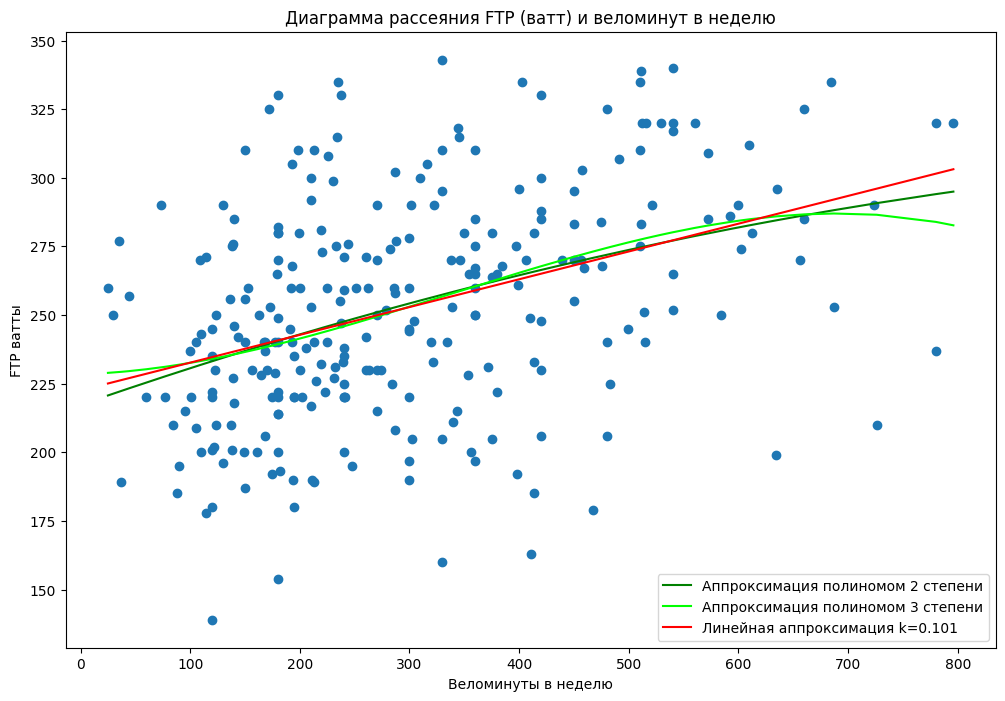

In [407]:
sc = data[['bike_minute', 'ftp_c']].sort_values(by='bike_minute')
plt.figure(figsize=(12,8))
plt.scatter(sc['bike_minute'], sc['ftp_c'])

z = np.polyfit(sc['bike_minute'], sc['ftp_c'], 2)
p = np.poly1d(z)
plt.plot(sc['bike_minute'], p(sc['bike_minute']), color='green', label = 'Аппроксимация полиномом 2 степени')

z = np.polyfit(sc['bike_minute'], sc['ftp_c'], 3)
p = np.poly1d(z)
plt.plot(sc['bike_minute'], p(sc['bike_minute']), color='lime', label = 'Аппроксимация полиномом 3 степени')


z = np.polyfit(sc['bike_minute'], sc['ftp_c'], 1)
p = np.poly1d(z)
plt.plot(sc['bike_minute'], p(sc['bike_minute']), color='red', label = f'Линейная аппроксимация k={round(z[0], 3)}')

plt.title('Диаграмма рассеяния FTP (ватт) и веломинут в неделю')
plt.ylabel('FTP ватты')
plt.xlabel('Веломинуты в неделю')
plt.legend()
plt.show()

In [408]:
print(f'Коэффициент линиейной аппроксимации FTP и веломинут: {round(z[0], 3)}')
print(f'Это можно интерпретировать так: у спортсменов, которые тренируются в неделю на один час больше, в среднем и FTP больше на {round(z[0] * 60, 3)} ватт')

Коэффициент линиейной аппроксимации FTP и веломинут: 0.101
Это можно интерпретировать так: у спортсменов, которые тренируются в неделю на один час больше, в среднем и FTP больше на 6.074 ватт


Однако, при этом данные, хорошо аппоксимируются и квадратичной фукнцией, которая показывает уменьшающийся прирост на больших веломинутах

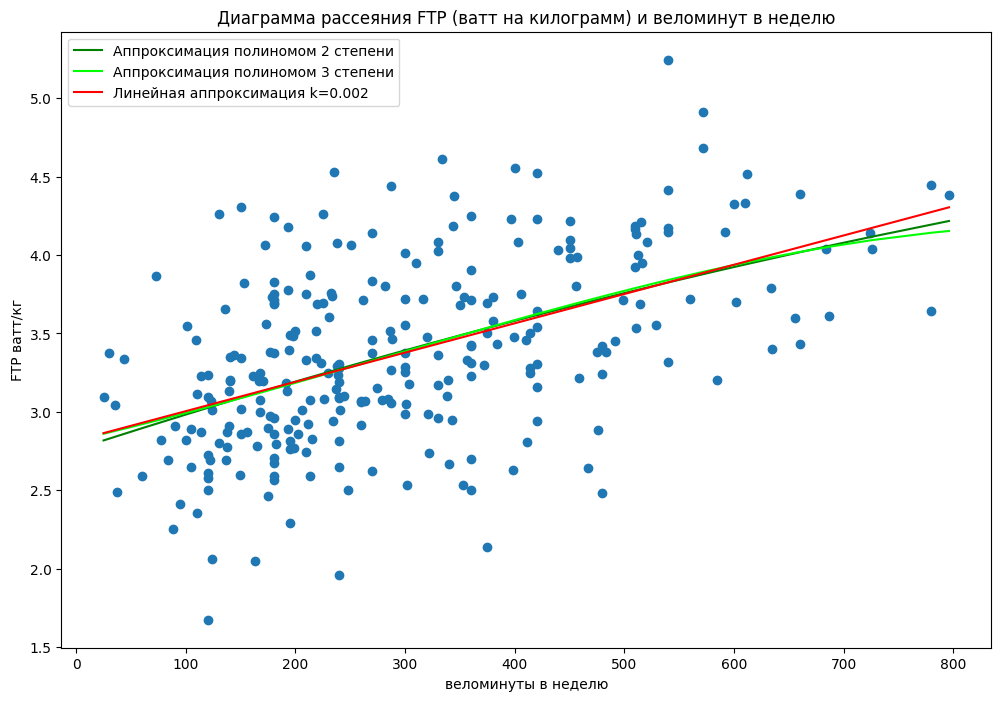

In [409]:
sc = data[['bike_minute', 'ftp_weigth']].sort_values(by='bike_minute')
plt.figure(figsize=(12,8))
plt.scatter(sc['bike_minute'], sc['ftp_weigth'])

z = np.polyfit(sc['bike_minute'], sc['ftp_weigth'], 2)
p = np.poly1d(z)
plt.plot(sc['bike_minute'], p(sc['bike_minute']), color='green', label = 'Аппроксимация полиномом 2 степени')

z = np.polyfit(sc['bike_minute'], sc['ftp_weigth'], 3)
p = np.poly1d(z)
plt.plot(sc['bike_minute'], p(sc['bike_minute']), color='lime', label = 'Аппроксимация полиномом 3 степени')


z = np.polyfit(sc['bike_minute'], sc['ftp_weigth'], 1)
p = np.poly1d(z)
plt.plot(sc['bike_minute'], p(sc['bike_minute']), color='red', label = f'Линейная аппроксимация k={round(z[0], 3)}')

plt.title('Диаграмма рассеяния FTP (ватт на килограмм) и веломинут в неделю')
plt.ylabel('FTP ватт/кг')
plt.xlabel('веломинуты в неделю')
plt.legend()
plt.show()

In [410]:
print(f'Коэффициент линиейной аппроксимации FTP и веломинут: {round(z[0], 3)}')
print(f'Это можно интерпретировать так: у спортсменов, которые тренируются в неделю на один час больше, в среднем и FTP больше на {round(z[0] * 60, 3)} ватт/кг')

Коэффициент линиейной аппроксимации FTP и веломинут: 0.002
Это можно интерпретировать так: у спортсменов, которые тренируются в неделю на один час больше, в среднем и FTP больше на 0.112 ватт/кг


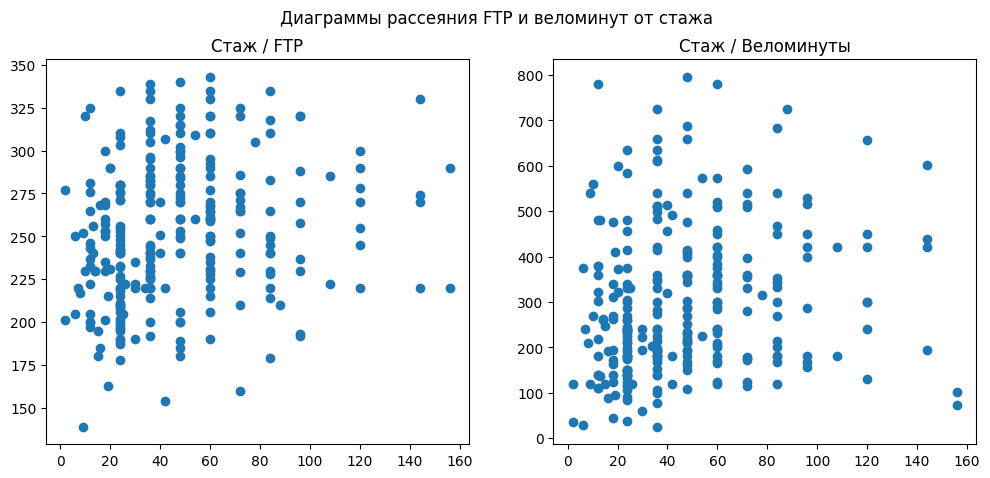

In [411]:
f, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].scatter(data['stag_r'], data['ftp_c'])
ax[0].set_title('Стаж / FTP')
ax[1].scatter(data['stag_r'], data['bike_minute'])
ax[1].set_title('Стаж / Веломинуты')
plt.suptitle('Диаграммы рассеяния FTP и веломинут от стажа')
plt.show()

Каких-то зависимостей от стажа из диаграммы рассеяния не обнаруживается

**Промежуточный итог**

Между веломинутами и FTP обнаруживается средняя положительная корреляция. Коэффициент линейной взаимосвязи около 0.1

# Когортный анализ

### Когорты по FTP

Разделим спортсменов на когорты **по указанному FTP** - от 190 до 330+ с шагом в 20 ватт

In [412]:
ftp_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
ftp_stag_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))

qstr_last = ''
ftpbox = dict()
data['ch_ftp'] = f'FTP{ftp_lim}'
for i in range(190, 350, 20):
    qstr = qstr_last + 'ftp_c <= ' + str(i+1)
    print(f'Условие для отбора когорты {i}: {qstr}')
    ftpbox[i]= data.query(qstr)[['bike_minute', 'stag_r']]
    ch_index = data.query(qstr).index
    data.loc[ch_index, 'ch_ftp'] = 'FTP' + str(i)
    ftp_describe.loc[i] = ftpbox[i]['bike_minute'].describe()
    ftp_stag_describe.loc[i] = ftpbox[i]['stag_r'].describe()
    qstr_last =  str(i+1) + ' < '
    qstr = qstr_last + 'ftp_c <= ' + str(ftp_lim)
ftpbox[ftp_lim]= data.query(qstr)[['bike_minute', 'stag_r']]
print(f'Условие для отбора когорты {ftp_lim}: {qstr}')

ftp_describe.loc[ftp_lim] = ftpbox[ftp_lim]['bike_minute'].describe()
ftp_stag_describe.loc[ftp_lim] = ftpbox[ftp_lim]['stag_r'].describe()

Условие для отбора когорты 190: ftp_c <= 191
Условие для отбора когорты 210: 191 < ftp_c <= 211
Условие для отбора когорты 230: 211 < ftp_c <= 231
Условие для отбора когорты 250: 231 < ftp_c <= 251
Условие для отбора когорты 270: 251 < ftp_c <= 271
Условие для отбора когорты 290: 271 < ftp_c <= 291
Условие для отбора когорты 310: 291 < ftp_c <= 311
Условие для отбора когорты 330: 311 < ftp_c <= 331
Условие для отбора когорты 351: 331 < ftp_c <= 351


Таблица статистических характеристик когорт. Индекс - верхняя граница когорты

In [413]:
ftp_cohorts_stat = pd.merge(ftp_describe, ftp_stag_describe, how = 'left', left_index=True, right_index=True, suffixes=('_minute', '_stag'))
ftp_cohorts_stat

,count_minute,mean_minute,std_minute,min_minute,25%_minute,50%_minute,75%_minute,max_minute,count_stag,mean_stag,std_stag,min_stag,25%_stag,50%_stag,75%_stag,max_stag
190,16.0,221.500000,127.454567,37.0,120.00,194.5,307.50,467.0,16.0,36.687500,21.767617,9.0,22.75,27.0,48.0,84.0
210,31.0,257.129032,159.054234,84.0,133.50,182.0,348.00,726.0,31.0,33.225806,25.128615,2.0,21.00,24.0,42.0,96.0
230,44.0,219.863636,90.818652,60.0,168.75,206.0,264.75,483.0,44.0,47.909091,35.900909,7.0,24.00,36.0,60.0,156.0
250,47.0,265.744681,148.859354,30.0,167.50,225.0,327.50,780.0,47.0,42.574468,26.110755,6.0,24.00,36.0,60.0,120.0
270,48.0,307.270833,144.882012,25.0,198.25,286.5,387.75,687.0,48.0,50.000000,30.470774,9.0,24.00,48.0,60.0,144.0
290,40.0,349.955000,176.043669,35.0,214.00,336.0,483.75,724.0,40.0,52.350000,36.119140,2.0,24.00,42.0,63.0,156.0
310,22.0,340.818182,135.595209,150.0,216.25,323.0,442.50,635.0,22.0,49.636364,23.066251,18.0,36.00,48.0,60.0,120.0
330,18.0,469.777778,187.845542,172.0,344.25,514.0,555.00,796.0,18.0,59.222222,32.184314,10.0,39.00,54.0,72.0,144.0
351,7.0,459.000000,148.573214,235.0,366.50,510.0,525.50,684.0,7.0,49.714286,20.113961,24.0,36.00,48.0,60.0,84.0


Диаграммы размаха когорт

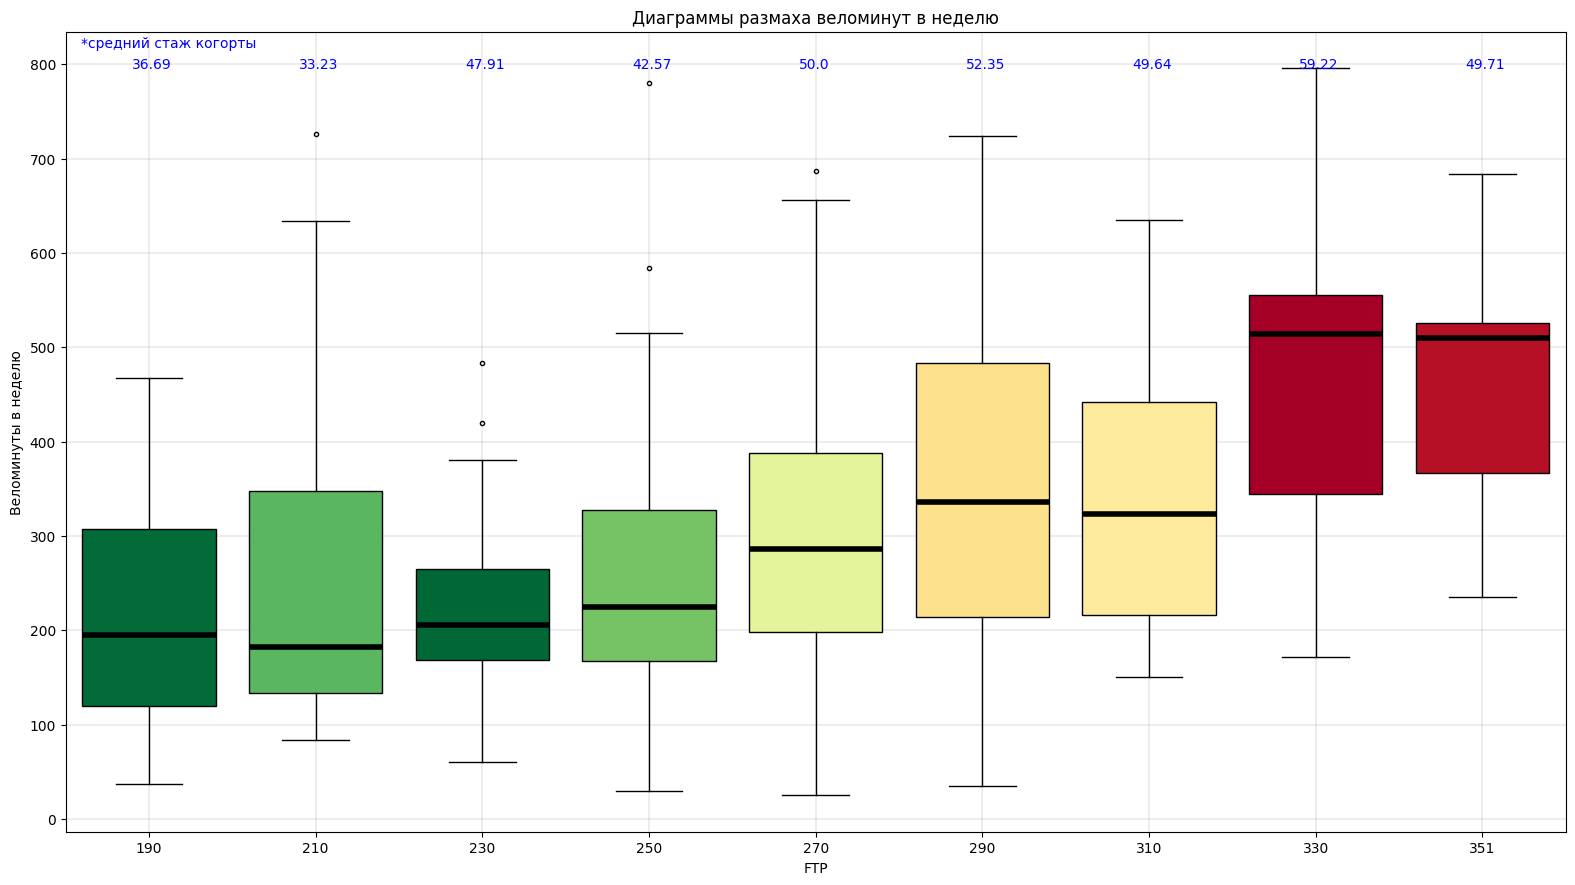

In [414]:
c = gradient_by_value(ftp_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for fb in ftpbox:
    ax.boxplot(ftpbox[fb]['bike_minute'], positions=[i], labels = [fb], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    ax.text(i-0.1, ftp_describe['max'].max(), f"{round(ftp_stag_describe.loc[fb, 'mean'], 2)}", color= 'blue')
    i +=1

plt.annotate('*средний стаж когорты', color = 'blue', xy=(0.01, 0.98), xycoords='axes fraction')
plt.title('Диаграммы размаха веломинут в неделю')
plt.xlabel('FTP')
plt.ylabel('Веломинуты в неделю')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

Как видно из диаграммы, спортсмены с 200 веломинутами есть во всех когортах FTP, кроме максимальной. Однако в "золотые середины" спортсмены с 3,5 часами тренировок в неделю входят только в категориях до 290 ватт. Менее 25% способны показывать высокие ватты при таком объеме веломинут, и с ростом FTP их доля только уменьшается.

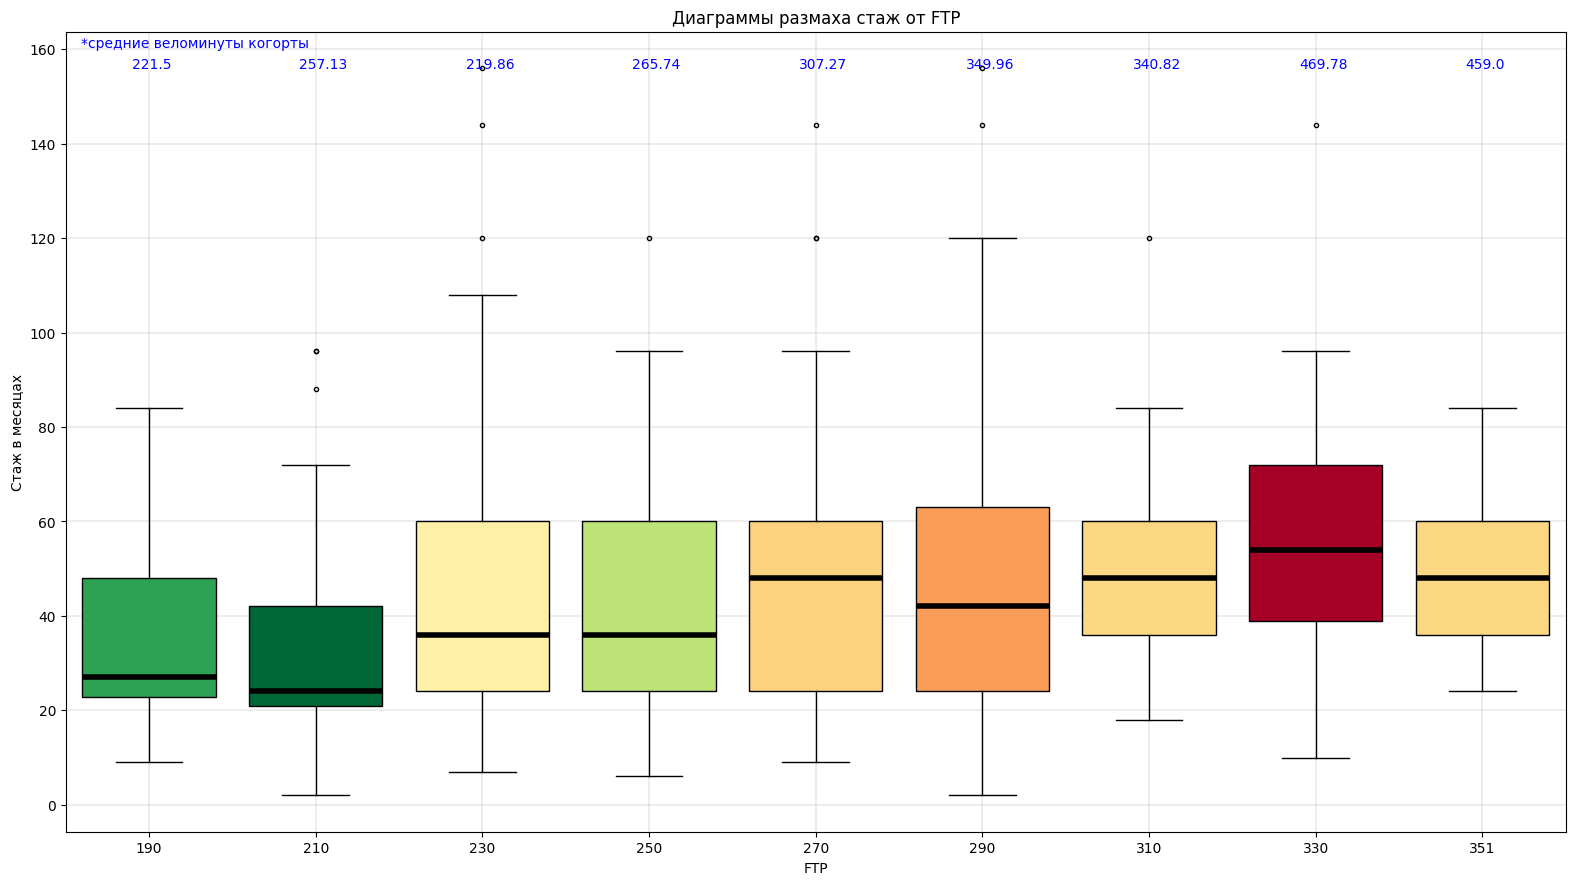

In [415]:
c = gradient_by_value(ftp_stag_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for fb in ftpbox:
    ax.boxplot(ftpbox[fb]['stag_r'], positions=[i], labels = [fb], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    ax.text(i-0.1, ftp_stag_describe['max'].max(), f"{round(ftp_describe.loc[fb, 'mean'], 2)}", color= 'blue')
    i +=1

plt.annotate('*средние веломинуты когорты', color = 'blue', xy=(0.01, 0.98), xycoords='axes fraction')
plt.title('Диаграммы размаха стаж от FTP')
plt.xlabel('FTP')
plt.ylabel('Стаж в месяцах')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

*Цвет тела середины "ящика с усами" определяется нормировкой среднего значения когорты по трехцветному градиенту, где красный - максимальное среднее значение целевого показателя среди всех когорт, зеленый - минимальное значение, желтый - среднее значение.*

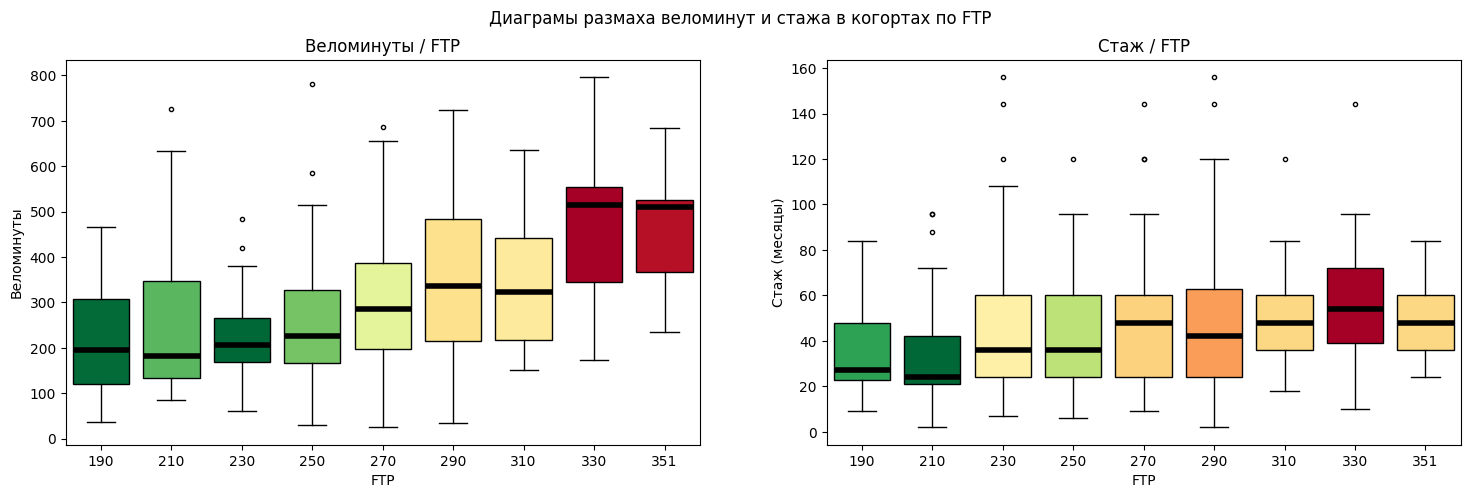

In [416]:
f, ax = plt.subplots(1, 2, figsize=(18,5))

c = gradient_by_value(ftp_describe['mean'])
i = 0
for fb in ftpbox:
    ax[0].boxplot(ftpbox[fb]['bike_minute'], positions=[i], labels = [fb], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
ax[0].set_title('Веломинуты / FTP')
ax[0].set_xlabel('FTP')
ax[0].set_ylabel('Веломинуты')


c = gradient_by_value(ftp_stag_describe['mean'])
i = 0
for fb in ftpbox:
    ax[1].boxplot(ftpbox[fb]['stag_r'], positions=[i], labels = [fb], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
ax[1].set_title('Стаж / FTP')
ax[1].set_xlabel('FTP')
ax[1].set_ylabel('Стаж (месяцы)')

plt.suptitle('Диаграмы размаха веломинут и стажа в когортах по FTP')
plt.show()



В когортах по FTP проявляется взаимосвязь с веломинутами. С ростом FTP, растут и веломинуты, которые указывали спортсмены в опросе. Однако. не стоит понимать это как прямую зависимость и закон. Например, спортсмены с 200 веломинутами есть в всех когортах, кроме максимального FTP, а в "золотую середину" входят в когортах до 270 ватт.

Связи стажа с ростом FTP - не обнаруживается. Во всех когортах по FTP вполне сопоставимые значения тренировочного стажа.

### Когорты по веломинутам

Разделим спортсменов на когорты **по веломинутам** в минутах - от 60 до 600+ с шагом в 60

In [417]:
bikeminut_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
bikeminut_stag_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
data['ch_bm'] = f'веломин{bike_minute_lim}'
qstr_last = ''
bikeminutbox = dict()
for i in range(90, 600, 60):
    qstr = qstr_last + 'bike_minute <= ' + str(i+1)
    print(f'Условие для отбора когорты {i}: {qstr}')
    bikeminutbox[i] = data.query(qstr)[['ftp_c', 'stag_r']]
    ch_index = data.query(qstr).index
    data.loc[ch_index, 'ch_bm'] = 'веломин' + str(i).zfill(3)
    qstr_last =  str(i+1) + ' < '
    bikeminut_describe.loc[i] = bikeminutbox[i]['ftp_c'].describe()
    bikeminut_stag_describe.loc[i] = bikeminutbox[i]['stag_r'].describe()
    qstr = qstr_last + 'bike_minute <= ' + str(bike_minute_lim)
bikeminutbox[bike_minute_lim]= data.query(qstr)[['ftp_c', 'stag_r']]
print(f'Условие для отбора когорты {bike_minute_lim}: {qstr}')

bikeminut_describe.loc[bike_minute_lim] = bikeminutbox[bike_minute_lim]['ftp_c'].describe()
bikeminut_stag_describe.loc[bike_minute_lim] = bikeminutbox[bike_minute_lim]['stag_r'].describe()



Условие для отбора когорты 90: bike_minute <= 91
Условие для отбора когорты 150: 91 < bike_minute <= 151
Условие для отбора когорты 210: 151 < bike_minute <= 211
Условие для отбора когорты 270: 211 < bike_minute <= 271
Условие для отбора когорты 330: 271 < bike_minute <= 331
Условие для отбора когорты 390: 331 < bike_minute <= 391
Условие для отбора когорты 450: 391 < bike_minute <= 451
Условие для отбора когорты 510: 451 < bike_minute <= 511
Условие для отбора когорты 570: 511 < bike_minute <= 571
Условие для отбора когорты 800: 571 < bike_minute <= 800


Таблица статистических характеристик когорт. Индекс - верхняя граница когорты

In [418]:
bikeminute_cohorts_stat = pd.merge(bikeminut_describe, bikeminut_stag_describe, how = 'left', left_index=True, right_index=True, suffixes=('_ftp', '_stag'))
bikeminute_cohorts_stat

,count_ftp,mean_ftp,std_ftp,min_ftp,25%_ftp,50%_ftp,75%_ftp,max_ftp,count_stag,mean_stag,std_stag,min_stag,25%_stag,50%_stag,75%_stag,max_stag
90,11.0,232.090909,36.497821,185.0,202.50,220.0,258.50,290.0,11.0,33.818182,41.947153,2.0,17.00,24.0,33.0,156.0
150,38.0,229.789474,35.222964,139.0,203.75,228.5,249.00,310.0,38.0,35.842105,31.084476,2.0,18.25,24.0,40.5,156.0
210,52.0,241.269231,37.301167,154.0,220.00,239.0,261.25,330.0,52.0,48.307692,28.456736,8.0,24.00,36.0,60.0,144.0
270,43.0,251.976744,35.060144,189.0,228.50,242.0,272.00,335.0,43.0,37.255814,22.533671,7.0,24.00,30.0,48.0,120.0
330,29.0,253.241379,42.450522,160.0,225.00,252.0,290.00,343.0,29.0,50.103448,29.496180,12.0,24.00,48.0,60.0,120.0
390,28.0,255.678571,32.997254,197.0,230.25,264.5,271.25,318.0,28.0,46.142857,23.468993,6.0,24.00,48.0,60.0,84.0
450,23.0,260.826087,43.686541,163.0,240.50,270.0,286.50,335.0,23.0,73.347826,36.200965,19.0,48.00,60.0,96.0,144.0
510,17.0,274.176471,44.792906,179.0,245.00,275.0,307.00,339.0,17.0,39.823529,20.025719,12.0,24.00,36.0,48.0,84.0
570,12.0,296.250000,34.837610,240.0,261.75,318.5,320.00,340.0,12.0,56.916667,29.484845,9.0,39.00,60.0,75.0,96.0
800,20.0,281.300000,36.776852,199.0,265.75,285.5,309.75,335.0,20.0,54.300000,33.524696,12.0,36.00,48.0,63.0,144.0


Диаграммы размаха когорт

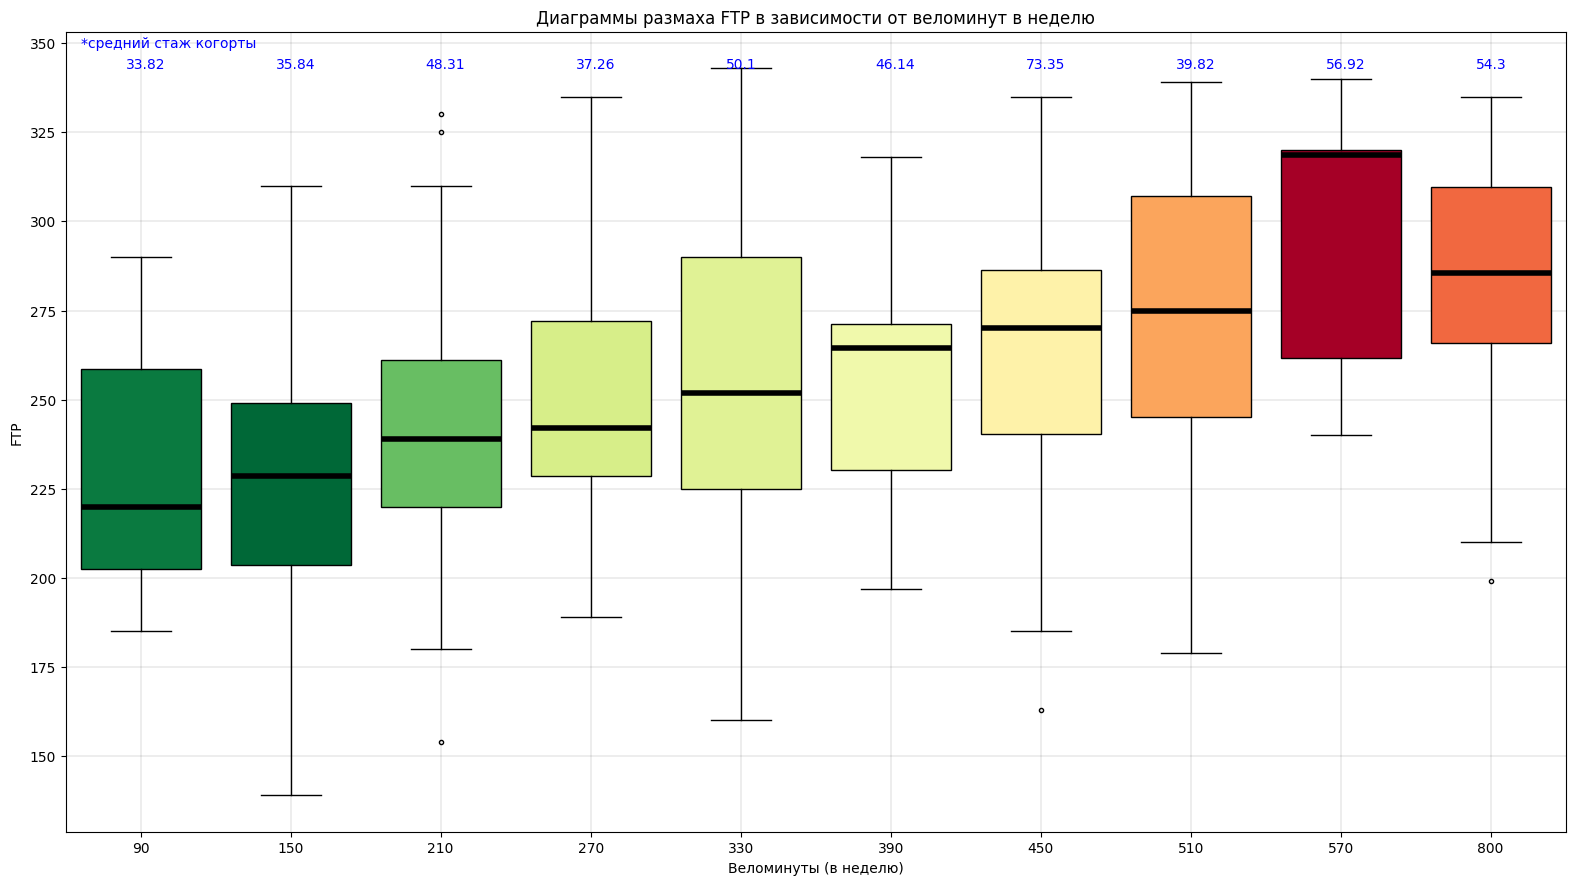

In [419]:
c = gradient_by_value(bikeminut_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for bk in bikeminutbox:
    ax.boxplot(bikeminutbox[bk]['ftp_c'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    ax.text(i-0.1, bikeminut_describe['max'].max(), f"{round(bikeminut_stag_describe.loc[bk, 'mean'], 2)}", color= 'blue')
    i +=1

plt.annotate('*средний стаж когорты', color = 'blue', xy=(0.01, 0.98), xycoords='axes fraction')
plt.title('Диаграммы размаха FTP в зависимости от веломинут в неделю')
plt.xlabel('Веломинуты (в неделю)')
plt.ylabel('FTP')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

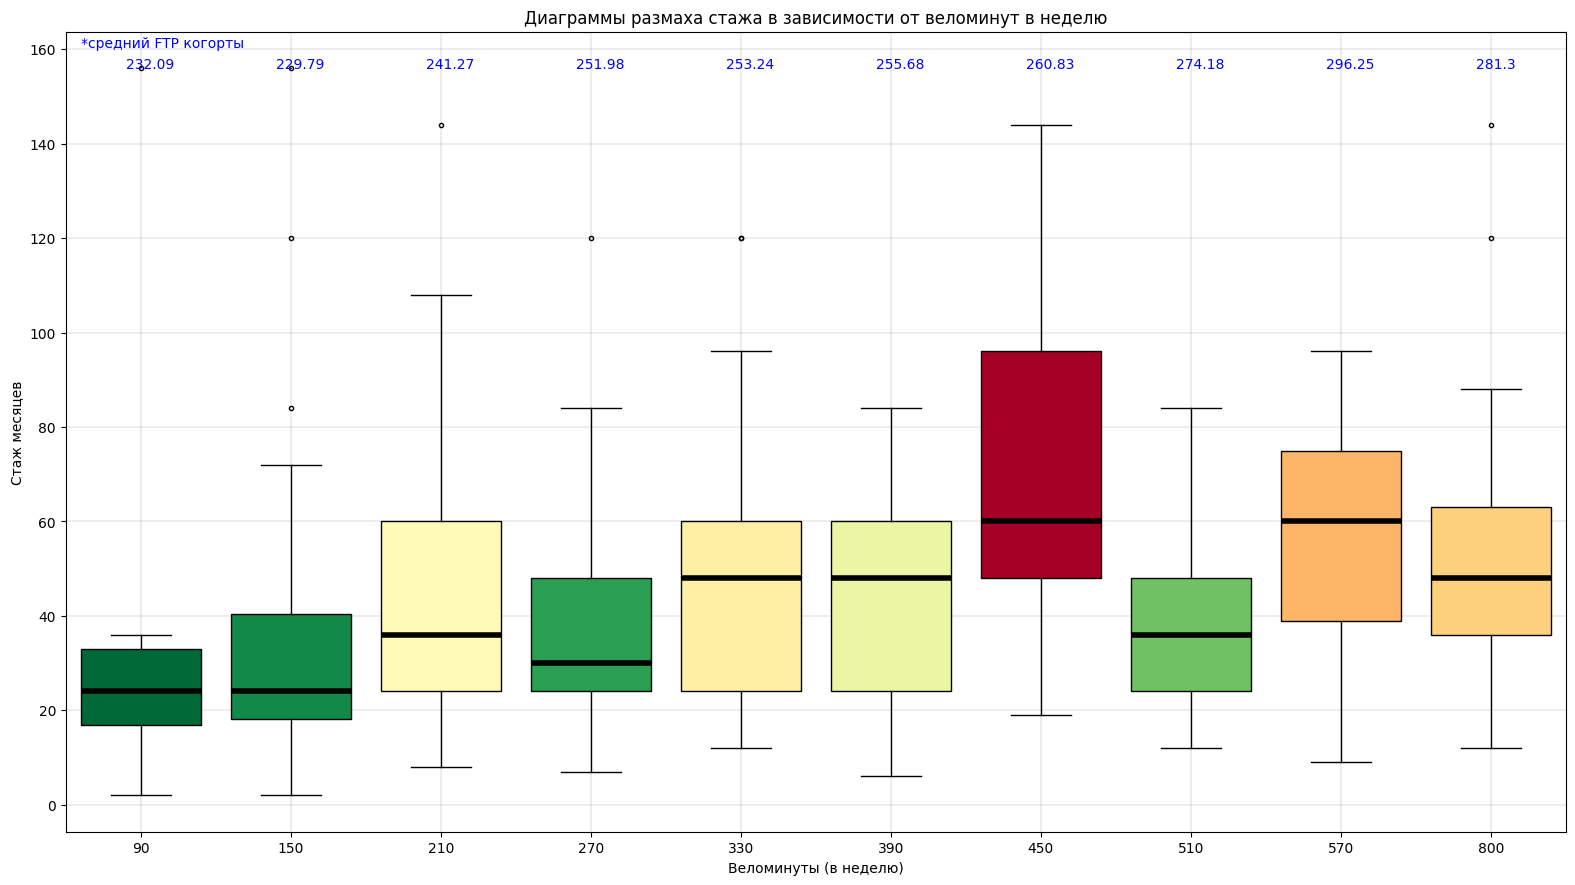

In [420]:
c = gradient_by_value(bikeminut_stag_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for bk in bikeminutbox:
    ax.boxplot(bikeminutbox[bk]['stag_r'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    ax.text(i-0.1, bikeminut_stag_describe['max'].max(), f"{round(bikeminut_describe.loc[bk, 'mean'], 2)}", color= 'blue')
    i +=1
plt.annotate('*средний FTP когорты', color = 'blue', xy=(0.01, 0.98), xycoords='axes fraction')
plt.title('Диаграммы размаха стажа в зависимости от веломинут в неделю')
plt.xlabel('Веломинуты (в неделю)')
plt.ylabel('Стаж месяцев')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

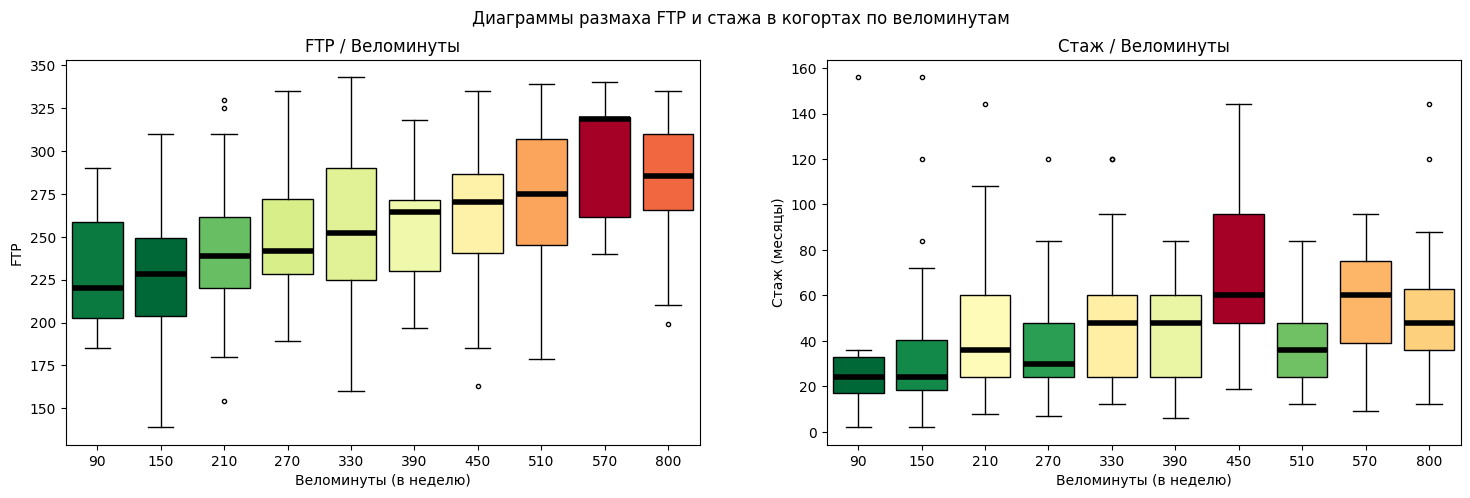

In [421]:
f, ax = plt.subplots(1, 2, figsize=(18,5))

c = gradient_by_value(bikeminut_describe['mean'])
i = 0
for bk in bikeminutbox:
    ax[0].boxplot(bikeminutbox[bk]['ftp_c'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
ax[0].set_title('FTP / Веломинуты')
ax[0].set_xlabel('Веломинуты (в неделю)')
ax[0].set_ylabel('FTP')


c = gradient_by_value(bikeminut_stag_describe['mean'])
i = 0
for bk in bikeminutbox:
    ax[1].boxplot(bikeminutbox[bk]['stag_r'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
ax[1].set_title('Стаж / Веломинуты')
ax[1].set_xlabel('Веломинуты (в неделю)')
ax[1].set_ylabel('Стаж (месяцы)')

plt.suptitle('Диаграммы размаха FTP и стажа в когортах по веломинутам')
plt.show()

В когортах веломинут также прослеживается взаимосвязь роста веломинут с ростом FTP. Также можно проследить, что спортсмены с FTP 250 ваттами есть во всех когортах, а в когортах от 180 до 480 минут такие спортсмены входят в "золотую середину".

Связи стажа от роста веломинут не обнаруживается.

### Когорты по тренирочному стажу

Разделим спортменов на когорты **по тренировочному стажу** в месяцах - от 18 до 90+ с шагом в 12

In [422]:
stag_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
stag_ftp_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
data['ch_st'] = f'стаж{stag_minute_lim}'
qstr_last = ''
stagbox = dict()
for i in range(18, 100, 12):
    qstr = qstr_last + 'stag_r <= ' + str(i+1)
    print(f'Условие для отбора когорты {i}: {qstr}')
    stagbox[i]= data.query(qstr)[['bike_minute', 'ftp_c']]
    stag_describe.loc[i] = stagbox[i]['bike_minute'].describe()
    stag_ftp_describe.loc[i] = stagbox[i]['ftp_c'].describe()
    ch_index = data.query(qstr).index
    data.loc[ch_index, 'ch_st'] = 'стаж' + str(i).zfill(3)
    qstr_last =  str(i+1) + ' < '
qstr = qstr_last + 'stag_r <= ' + str(stag_minute_lim)
stagbox[stag_minute_lim]= data.query(qstr)[['bike_minute', 'ftp_c']]
print(f'Условие для отбора когорты {stag_minute_lim}: {qstr}')
stag_describe.loc[stag_minute_lim] = stagbox[stag_minute_lim]['bike_minute'].describe()
stag_ftp_describe.loc[stag_minute_lim] = stagbox[stag_minute_lim]['ftp_c'].describe()


Условие для отбора когорты 18: stag_r <= 19
Условие для отбора когорты 30: 19 < stag_r <= 31
Условие для отбора когорты 42: 31 < stag_r <= 43
Условие для отбора когорты 54: 43 < stag_r <= 55
Условие для отбора когорты 66: 55 < stag_r <= 67
Условие для отбора когорты 78: 67 < stag_r <= 79
Условие для отбора когорты 90: 79 < stag_r <= 91
Условие для отбора когорты 158: 91 < stag_r <= 158


In [423]:
stag_cohorts_stat = pd.merge(stag_describe, stag_ftp_describe, how = 'left', left_index=True, right_index=True, suffixes=('_minute', '_ftp'))
stag_cohorts_stat

,count_minute,mean_minute,std_minute,min_minute,25%_minute,50%_minute,75%_minute,max_minute,count_ftp,mean_ftp,std_ftp,min_ftp,25%_ftp,50%_ftp,75%_ftp,max_ftp
18,44.0,254.300000,159.627552,30.0,132.75,230.0,344.25,780.0,44.0,235.909091,38.362299,139.0,205.00,236.0,257.75,325.0
30,56.0,239.464286,128.916458,37.0,149.75,221.0,290.25,634.0,56.0,236.821429,36.682474,178.0,208.75,231.5,259.75,335.0
42,48.0,316.895833,177.905215,25.0,180.00,257.0,485.00,724.0,48.0,259.500000,39.624836,154.0,230.00,260.0,285.00,339.0
54,35.0,327.714286,163.444463,109.0,213.00,286.0,403.00,796.0,35.0,268.000000,42.483215,180.0,249.50,273.0,299.50,340.0
66,35.0,336.942857,140.907968,120.0,235.00,338.0,411.50,780.0,35.0,265.542857,38.313984,190.0,236.50,261.0,291.00,343.0
78,15.0,330.600000,157.750164,114.0,178.00,330.0,453.50,592.0,15.0,263.000000,42.245879,160.0,246.00,267.0,280.50,325.0
90,16.0,345.562500,183.793351,120.0,195.00,317.0,454.25,726.0,16.0,251.000000,42.185305,179.0,226.00,242.5,269.50,335.0
158,24.0,334.666667,164.320383,73.0,181.50,349.0,441.75,656.0,24.0,261.541667,38.848624,192.0,228.00,270.0,288.50,330.0


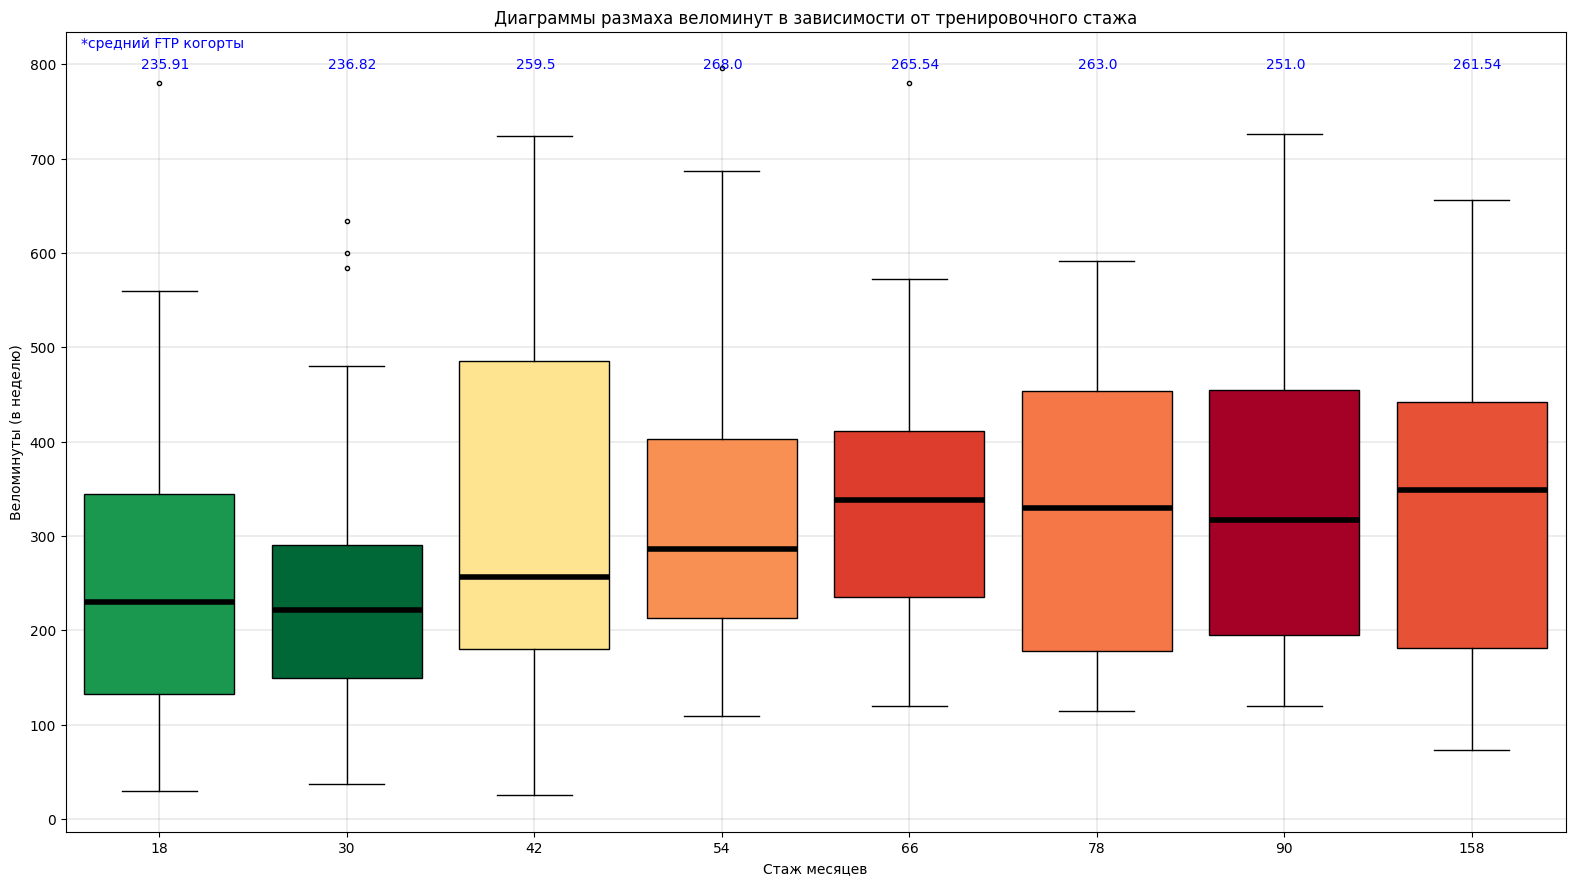

In [424]:
c = gradient_by_value(stag_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for bk in stagbox:
    ax.boxplot(stagbox[bk]['bike_minute'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    ax.text(i-0.1, stag_describe['max'].max(), f"{round(stag_ftp_describe.loc[bk, 'mean'], 2)}", color= 'blue')
    i +=1
plt.annotate('*средний FTP когорты', color = 'blue', xy=(0.01, 0.98), xycoords='axes fraction')
plt.title('Диаграммы размаха веломинут в зависимости от тренировочного стажа')
plt.xlabel('Стаж месяцев')
plt.ylabel('Веломинуты (в неделю)')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

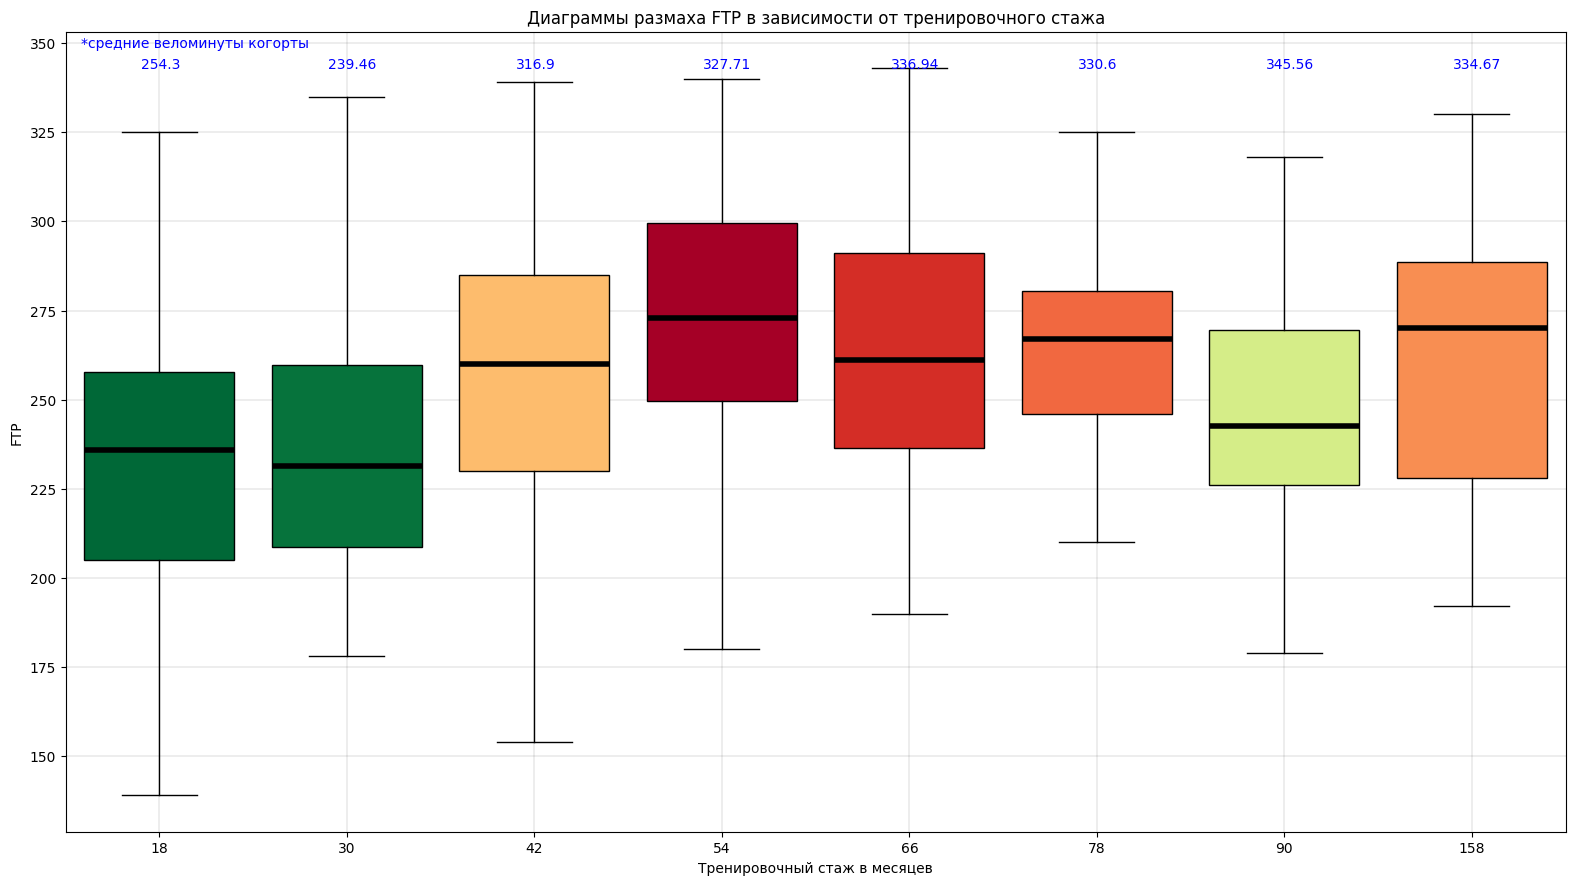

In [425]:
c = gradient_by_value(stag_ftp_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for bk in stagbox:
    ax.boxplot(stagbox[bk]['ftp_c'], positions=[i], labels = [bk], widths = 0.8 , sym = '',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    ax.text(i-0.1, stag_ftp_describe['max'].max(), f"{round(stag_describe.loc[bk, 'mean'], 2)}", color= 'blue')
    i +=1
plt.annotate('*средние веломинуты когорты', color = 'blue', xy=(0.01, 0.98), xycoords='axes fraction')
plt.title('Диаграммы размаха FTP в зависимости от тренировочного стажа')
plt.xlabel('Тренировочный стаж в месяцев')
plt.ylabel('FTP')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

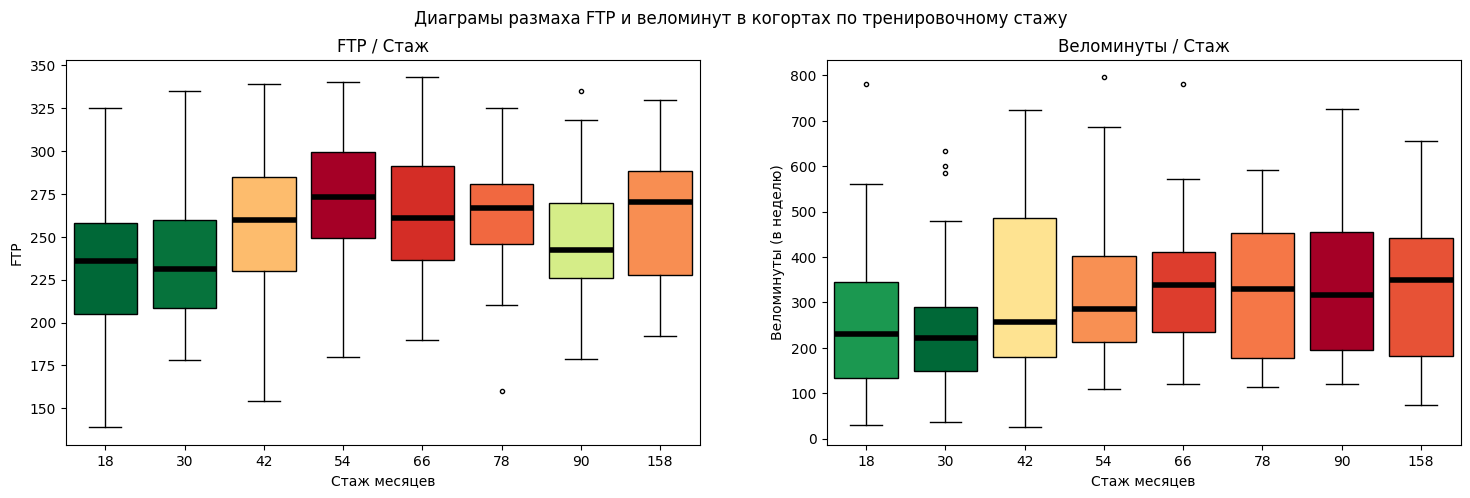

In [426]:
f, ax = plt.subplots(1, 2, figsize=(18,5))

c = gradient_by_value(stag_ftp_describe['mean'])
i = 0
for bk in stagbox:
    ax[0].boxplot(stagbox[bk]['ftp_c'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
ax[0].set_title('FTP / Стаж')
ax[0].set_xlabel('Стаж месяцев')
ax[0].set_ylabel('FTP')


c = gradient_by_value(stag_describe['mean'])
i = 0
for bk in stagbox:
    ax[1].boxplot(stagbox[bk]['bike_minute'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
ax[1].set_title('Веломинуты / Стаж')
ax[1].set_xlabel('Стаж месяцев')
ax[1].set_ylabel('Веломинуты (в неделю)')

plt.suptitle('Диаграмы размаха FTP и веломинут в когортах по тренировочному стажу')
plt.show()

При анализе когорт по стажу, уже проявляется зависимость FTP и веломинут от стажа. Наибольший уровень FTP показывают спортсмены на 4-6 годы тренировок. После этого значения FTP немного падают.

У новичков меньше всего веломинут. С ростом стажа веломинуты стабилизируются примерно на уровне 300-400 минут в неделю.

Только единицы, видимо, остающиеся в спорте высоких достижений, продолжают поддерживать или наращивать объемы тренировок и показывать высокие FTP.

## Пересечение когорт

"Тепловая карта" количества спортсменов в координатах FTP / веломинут. По горизонтали - когорты FTP, по вертикали - когорты веломинут, в ячейках - количество спортсменов, которые вошли в соответствующие когорты по FTP и веломинутам.

In [427]:
dd = data.groupby(['ch_ftp', 'ch_bm'])['sport'].count()
dd = dd.reset_index()
dd = dd.pivot_table(index = 'ch_bm', columns = 'ch_ftp', values = 'sport')
dd = dd.fillna(0)
dd[::-1].style.apply(background_gradient_alltable, cmap='RdYlGn_r', m=dd.min().min(), M=dd.max().max(), low=0, high=0.1).format(precision=0)

ch_ftp,FTP190,FTP210,FTP230,FTP250,FTP270,FTP290,FTP310,FTP330,FTP351
ch_bm,,,,,,,,,
веломин800,0,2,0,2,2,7,2,4,1
веломин570,0,0,0,2,2,1,0,6,1
веломин510,1,1,1,2,3,3,3,1,2
веломин450,2,2,1,3,5,5,3,1,1
веломин390,0,4,4,3,10,4,1,2,0
веломин330,2,4,3,5,4,5,5,0,1
веломин270,1,2,12,9,8,5,3,2,1
веломин210,4,5,14,11,8,4,4,2,0
веломин150,4,9,7,9,4,4,1,0,0


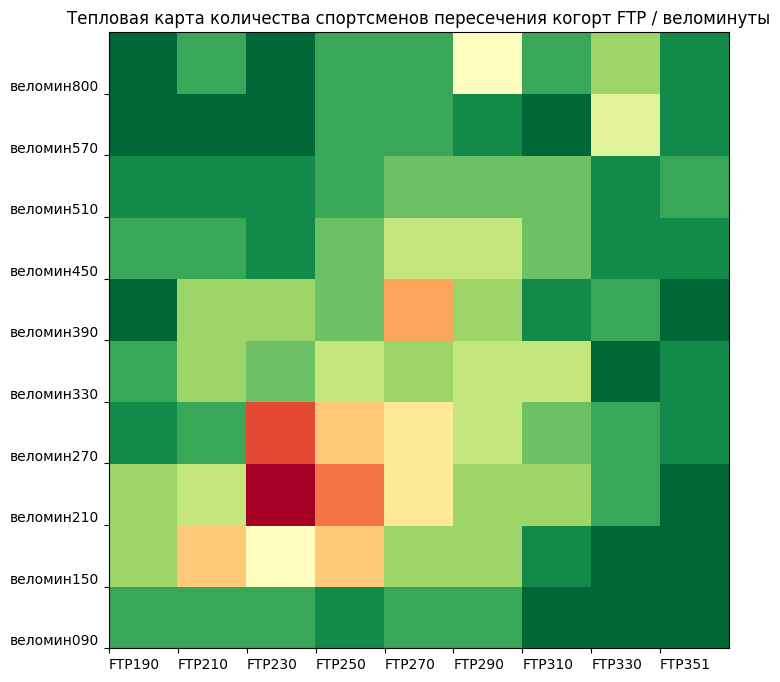

In [428]:
fig = plt.figure(figsize = (8, 8))
plt.pcolor(dd, cmap ='RdYlGn_r')
plt.xticks(range(len(dd.columns)), dd.columns, ha='left', va='top')
plt.yticks(range(len(dd.index)), dd.index, ha='right', va='bottom')
plt.title('Тепловая карта количества спортсменов пересечения когорт FTP / веломинуты')
plt.show()

В нижнем левом углу - те, у кого мало веломинут и низкий FTP. В правом верхнем углу - спортсмены с высоким FTP и большим количеством веломинут. В левом верхнем углу - те, кто имеет много веломинут, но при этом низкий FTP. Самые крутые - кто с высоким FTP и малым количеством веломинут - в правом нижнем углу.

Как видно больше всего спортсменов оказались в ячейках по диагонали от нижнего левого угла до верхнего правого тепловой карты. Это также говорит о взаимозависимости роста веломинут и FTP, но и показывает, что эта связь не строго линейная.

Распределение спортсменов из когорт FTP по когортам веломинут

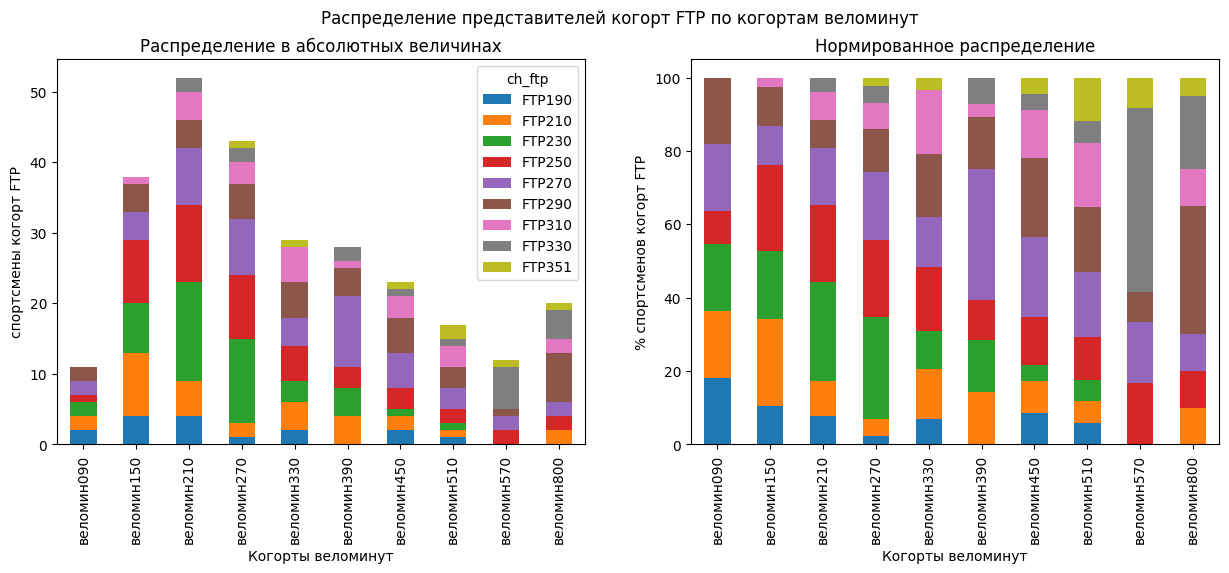

In [429]:
f, ax = plt.subplots(1, 2, figsize=(18,5))

dd = data.groupby(['ch_ftp', 'ch_bm'])['sport'].count()
dd = dd.reset_index()
dd = dd.pivot_table(index = 'ch_bm', columns = 'ch_ftp', values = 'sport')
dd = dd.fillna(0)

dd.plot.bar(ax = ax[0], stacked = True, figsize=(15,5))

ax[0].set_title('Распределение в абсолютных величинах')
ax[0].set_xlabel('Когорты веломинут')
ax[0].set_ylabel('спортсмены когорт FTP')

dd['sum'] = dd.sum(axis=1)
dd = dd.apply(lambda x: 100 * (x / x['sum']), axis=1)
dd = dd.drop(columns = 'sum')

dd.plot.bar(ax = ax[1], stacked = True, figsize=(15,5), legend = None)

ax[1].set_title('Нормированное распределение')
ax[1].set_xlabel('Когорты веломинут')
ax[1].set_ylabel('% спортсменов когорт FTP')

plt.suptitle('Распределение представителей когорт FTP по когортам веломинут')
plt.show()

На графиках более высокие секции - спортсмены с бОльшим FTP. Соответственно, если в когорте более высокие секции "шире в высоту", то это означает, что там больше спортсменов с бОльшим FTP. И на оборот, если более широкие нижние секции - в этой когорте больше спортсменов с меньшим FTP.

Как видно из графиков, с ростом веломинут в когортах растет и доля спортсменов с большим FTP. Что подтверждает взаимосвязь роста FTP с ростом веломинут.

"Тепловая карта" FTP в координатах веломинуты / стаж. По горизонтали - когорты стажа, по вертикали - когорты веломинут, в ячейках - среднее FTP для  спортсменов, которые вошли в соответствующие когорты по веломинутам и стажу.

In [430]:
dd = data.groupby(['ch_st', 'ch_bm'])['ftp_c'].mean()
dd = dd.reset_index()
dd = dd.pivot_table(index = 'ch_bm', columns = 'ch_st', values = 'ftp_c')
dd = dd.fillna(0)
dd[::-1].style.apply(background_gradient_alltable, cmap='RdYlGn_r', m=160, M=dd.max().max(), low=0, high=0.1).format(precision=0)

ch_st,стаж018,стаж030,стаж042,стаж054,стаж066,стаж078,стаж090,стаж158
ch_bm,,,,,,,,
веломин800,237,246,293,302,302,286,272,272
веломин570,286,0,284,340,305,280,265,320
веломин510,278,254,286,284,288,275,179,0
веломин450,163,280,232,250,269,275,283,274
веломин390,228,241,275,262,263,266,262,0
веломин330,246,243,257,284,259,239,220,260
веломин270,240,253,247,267,239,0,280,220
веломин210,237,236,244,234,263,273,233,220
веломин150,217,218,242,290,242,240,245,255


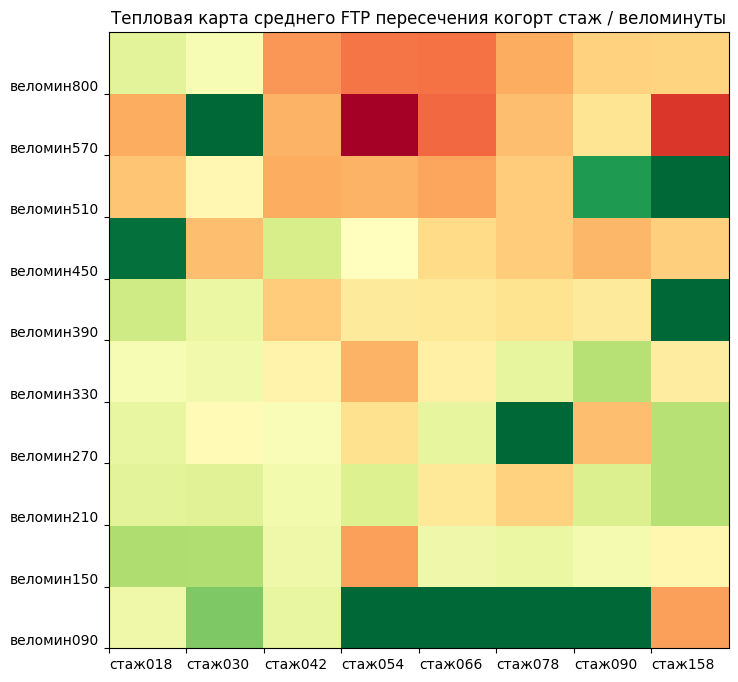

In [431]:
fig = plt.figure(figsize = (8, 8))
plt.pcolor(dd, cmap ='RdYlGn_r', vmin=160, vmax=dd.max().max())
plt.xticks(range(len(dd.columns)), dd.columns, ha='left', va='top')
plt.yticks(range(len(dd.index)), dd.index, ha='right', va='bottom')
plt.title('Тепловая карта среднего FTP пересечения когорт стаж / веломинуты')
plt.show()

**Промежуточные итоги**

Подтверждается взаимосвязь роста FTP с ростом веломинут. Кроме этого, обнаружилась нелинейная взаимосвязь FTP со стажем, а также выход на "плато" веломинут с ростом стажа.

# Сравнение спортсменов только с велотренировками и сочетающих другие виды активности

Разделим спортсменов на велосипедистов - те у кого только велотренировки, и условных "мультиспортсменов" - те у кого кроме вело, есть и тренировки по другим видам спорта.

*Стоит отметь, что в данном контексте "мультиспортсмен" не равно вид спорта "Триатлон", указанный в анкете*

In [432]:
velo_only = data[data['train_minute'] < 10].copy()
velo_plus = data[data['train_minute'] > 0].copy()
velo_plus['all_minute'] = velo_plus['bike_minute'] + velo_plus['train_minute']

In [433]:
#Проверка на аномалии
velo_plus.query('all_minute > 1200')[['weigth', 'gender', 'sport', 'bike_hours', 'train_hours', 'ftp', 'bike_minute', 'train_minute']]

,weigth,gender,sport,bike_hours,train_hours,ftp,bike_minute,train_minute
148,71.0,Мужской,Триатлон,08:41:31,12:00:00,290,521.0,720.0


Диаграммы рассеяния FTP и веломинут у велосипедистов, а у мультиспортсменов веломинут и длительность обычных тренировок

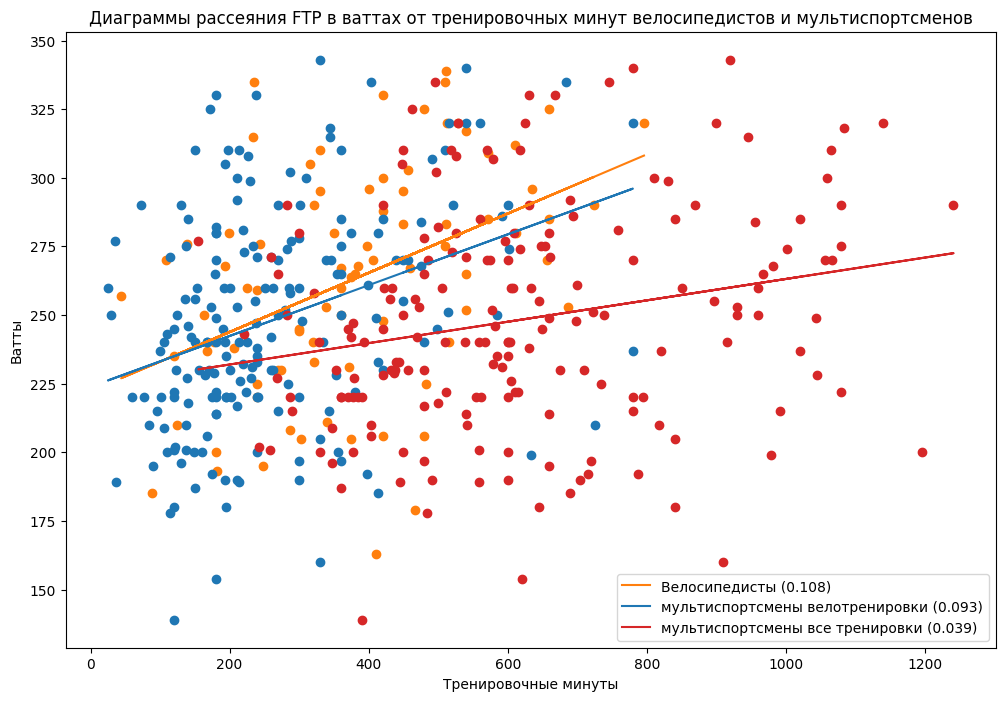

In [434]:
plt.figure(figsize=(12,8))
plt.scatter(velo_only['bike_minute'], velo_only['ftp_c'], color='tab:orange')
z = np.polyfit(velo_only['bike_minute'], velo_only['ftp_c'], 1)
p = np.poly1d(z)
l = f'Велосипедисты ({round(z[0], 3)})'
plt.plot(velo_only['bike_minute'], p(velo_only['bike_minute']), color='tab:orange', label = l)

plt.scatter(velo_plus['bike_minute'], velo_plus['ftp_c'], color='tab:blue')
z = np.polyfit(velo_plus['bike_minute'], velo_plus['ftp_c'], 1)
p = np.poly1d(z)
l = f'мультиспортсмены велотренировки ({round(z[0], 3)})'
plt.plot(velo_plus['bike_minute'], p(velo_plus['bike_minute']), color='tab:blue', label = l)

plt.scatter(velo_plus['all_minute'], velo_plus['ftp_c'], color='tab:red')
z = np.polyfit(velo_plus['all_minute'], velo_plus['ftp_c'], 1)
p = np.poly1d(z)
l = f'мультиспортсмены все тренировки ({round(z[0], 3)})'
plt.plot(velo_plus['all_minute'], p(velo_plus['all_minute']), color='tab:red', label = l)

plt.title('Диаграммы рассеяния FTP в ваттах от тренировочных минут велосипедистов и мультиспортсменов')
plt.ylabel('Ватты')
plt.xlabel('Тренировочные минуты')
plt.legend()
plt.show()

Статистические характеристики велосипедистов

In [435]:
velo_only[['ftp_c', 'bike_minute']].rename(columns = {'ftp_c' : 'FTP', 'bike_minute' : 'Веломинуты'}).describe().T

,count,mean,std,min,25%,50%,75%,max
FTP,83.0,263.168675,40.949052,163.0,236.0,267.0,292.5,339.0
Веломинуты,83.0,379.604819,161.830523,44.0,246.0,375.0,496.5,796.0


Статистические характеристики мультиспортсменов

In [436]:
velo_plus[['ftp_c', 'bike_minute', 'all_minute']].rename(columns = {'ftp_c' : 'FTP', 'bike_minute' : 'Веломинуты', 'all_minute' : 'Все тренировки'}).describe().T

,count,mean,std,min,25%,50%,75%,max
FTP,190.0,248.247368,40.146120,139.0,220.00,245.0,275.00,343.0
Веломинуты,190.0,263.610526,147.165083,25.0,167.25,224.0,343.75,780.0
Все тренировки,190.0,617.931579,227.251884,155.0,449.25,594.0,743.50,1241.0


Доля велотренировок у мультиспортсменов

In [437]:
velo_plus['train_prob'] = round(100 * velo_plus['bike_minute'] / velo_plus['all_minute'], 2)
print(f"Средняя доля велотренировок у мультиспортсменов - {round(velo_plus['train_prob'].mean(), 2)}%")

Средняя доля велотренировок у мультиспортсменов - 43.44%


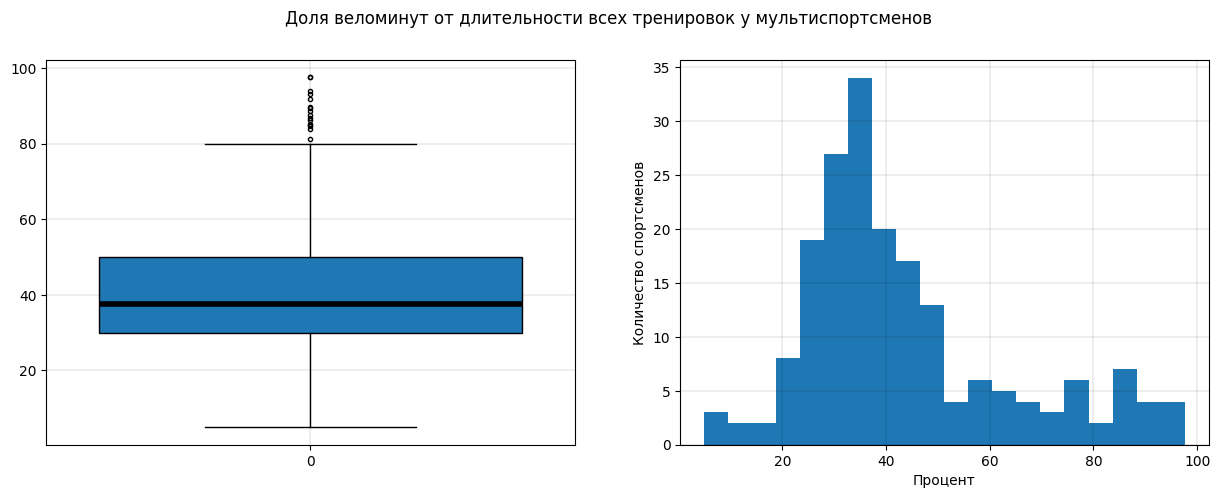

In [438]:
f, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].boxplot(velo_plus['train_prob'], positions=[0], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='tab:blue'), medianprops=dict(color='black', linewidth=4))
ax[0].grid(color='black', linestyle='-', linewidth=0.1)
#ax[0].set_title('Диаграмма размаха доли веломинут у мультиспортсменов')

ax[1].hist(velo_plus['train_prob'], bins = 20)
ax[1].grid(color='black', linestyle='-', linewidth=0.1)
#ax[1].set_title('Гисторгамма доли велотминут у мультиспортсменов')
ax[1].set_ylabel('Количество спортсменов')
ax[1].set_xlabel('Процент')
plt.suptitle('Доля веломинут от длительности всех тренировок у мультиспортсменов')
plt.show()

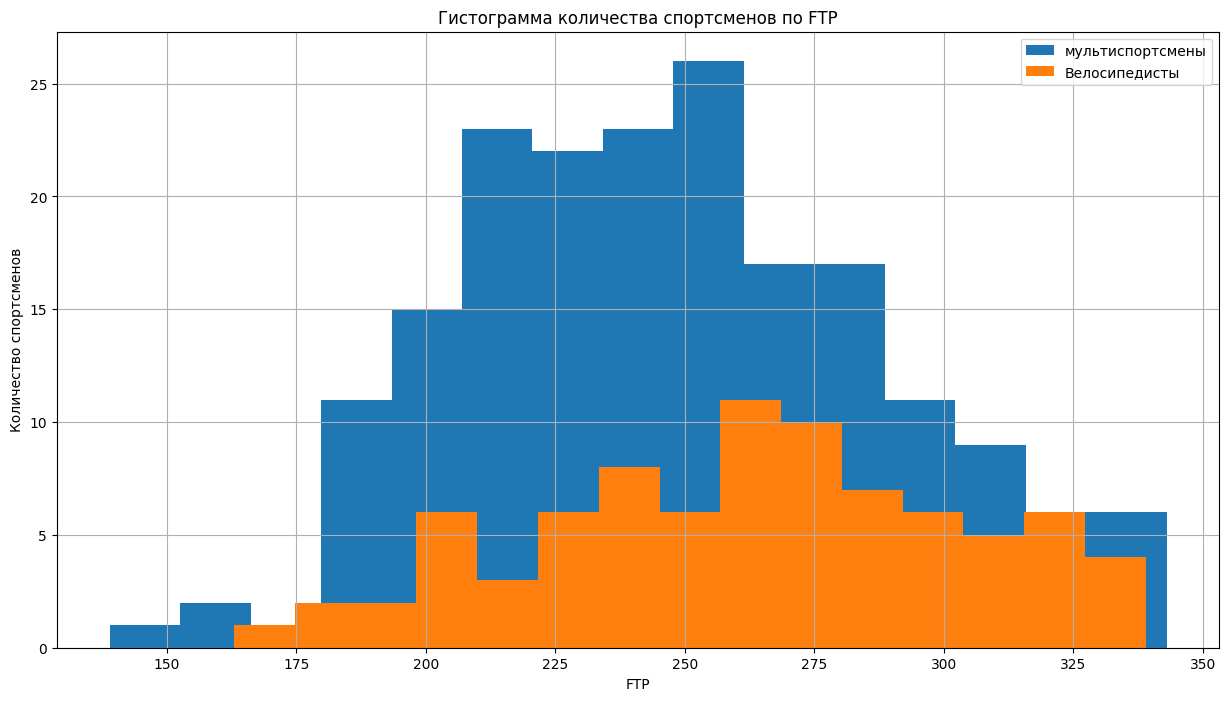

In [439]:
plt.figure(figsize=(15,8))
velo_plus['ftp_c'].hist(bins = 15, alpha = 1, color = 'tab:blue', label = 'мультиспортсмены')
velo_only['ftp_c'].hist(bins = 15, alpha = 1,  color = 'tab:orange', label = 'Велосипедисты')
plt.title('Гистограмма количества спортсменов по FTP')
plt.ylabel('Количество спортсменов')
plt.xlabel('FTP')
plt.legend()
plt.show()

Проверим гипотезу, что при сопоставимом объеме только велотренировок у велоиспедистов и мультиспортсменов, у первых будет выше FTP.

Вторая гипотеза: при сопоставимом FTP у велосипедистов и мультиспортсменов у первых будет больше только велотренировок.

Третья гипотеза: при сопоставимом FTP у велосипедистов и мультиспортсменов у последних общий объем всех тренировок будет больше, чем веломинут у велосипедистов

Проверку гипотез проведем только на спортсменах из середенной половины. Для этого возьмем границы из "золотой середины" статистических характетистик FTP и длительности тренировок

In [440]:
ftp_gold_min = train_stat.loc['FTP', '25%']
ftp_gold_max = train_stat.loc['FTP', '75%']
bikeminute_gold_min = train_stat.loc['Веломинуты', '25%']
bikeminute_gold_max = train_stat.loc['Веломинуты', '75%']
allminute_gold_min = velo_plus['all_minute'].describe().loc['25%']
allminute_gold_max = velo_plus['all_minute'].describe().loc['75%']

In [441]:
print(f"Границы серединной половины по FTP {ftp_gold_min} - {ftp_gold_max}")
print(f"Границы серединной половины по веломинутам {bikeminute_gold_min} - {bikeminute_gold_max}")
print(f"Границы серединной половины по минутам всех тренировок {allminute_gold_min} - {allminute_gold_max}")

Границы серединной половины по FTP 222.0 - 280.0
Границы серединной половины по веломинутам 180.0 - 400.0
Границы серединной половины по минутам всех тренировок 449.25 - 743.5


In [442]:
velo_compare = pd.DataFrame(columns = ('FTP', 'train_duration'))
velo_compare.loc['велосипедисты','FTP'] = round(velo_only.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'].mean(), 2)
velo_compare.loc['мультиспортсмены только вело','FTP'] = round(velo_plus.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'].mean(), 2)
velo_compare.loc['мультиспортсмены все тренировки','FTP'] = round(velo_plus.query('all_minute > @allminute_gold_min & all_minute < @allminute_gold_max')['ftp_c'].mean(), 2)


In [443]:
print(f"Средний FTP велосипедистов из золотой середины по длительности велотренировок - {velo_compare.loc['велосипедисты', 'FTP']} ватт")
print(f"Средний FTP мультиспортсменов из золотой середины по длительности велотренировок - {velo_compare.loc['мультиспортсмены только вело', 'FTP']} ватт")
print(f"Средний FTP мультиспортсменов из золотой середины по длительности всех тренировок - {velo_compare.loc['мультиспортсмены все тренировки', 'FTP']} ватт")

Средний FTP велосипедистов из золотой середины по длительности велотренировок - 253.56 ватт
Средний FTP мультиспортсменов из золотой середины по длительности велотренировок - 250.38 ватт
Средний FTP мультиспортсменов из золотой середины по длительности всех тренировок - 249.87 ватт


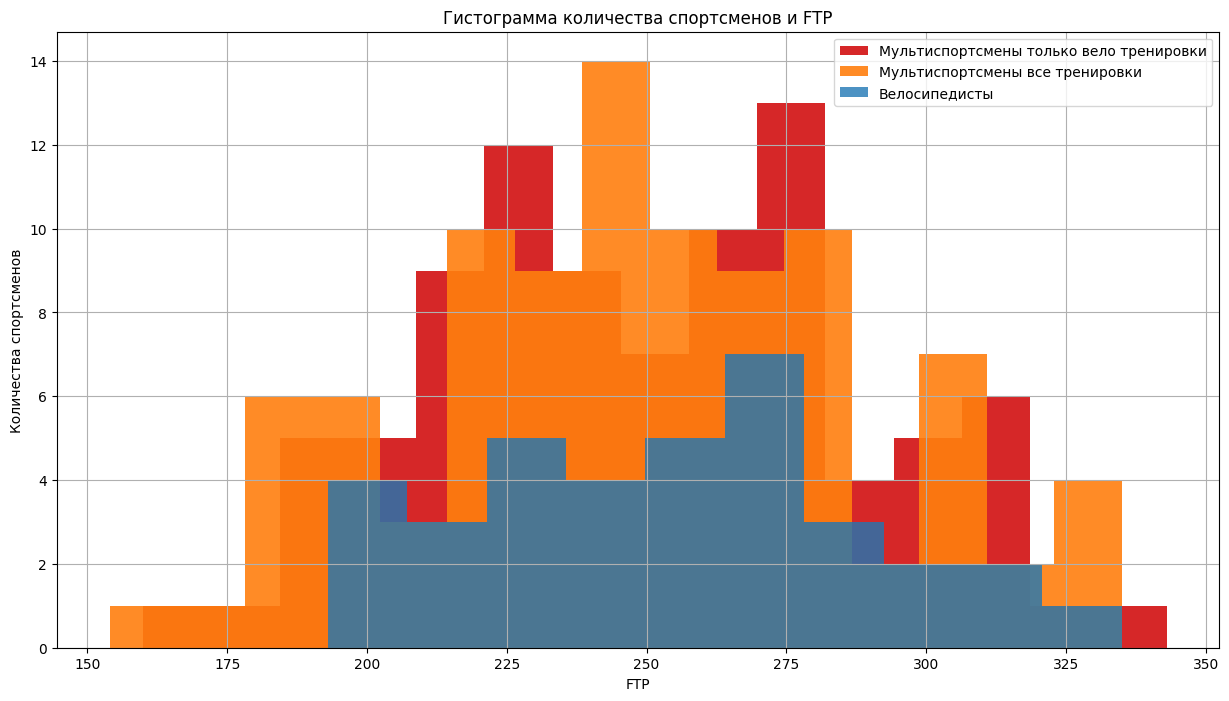

In [444]:
plt.figure(figsize=(15,8))


velo_plus.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'].hist(bins = 15, alpha = 1, color = 'tab:red', label = 'Мультиспортсмены только вело тренировки')
velo_plus.query('all_minute > @allminute_gold_min & all_minute < @allminute_gold_max')['ftp_c'].hist(bins = 15, alpha = 0.9,  color = 'tab:orange', label = 'Мультиспортсмены все тренировки')
velo_only.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'].hist(bins = 10, alpha = 0.8, color = 'tab:blue', label = 'Велосипедисты')
plt.title('Гистограмма количества спортсменов и FTP')
plt.ylabel('Количества спортсменов')
plt.xlabel('FTP')
plt.legend()
plt.show()

In [445]:
test_selection(velo_only.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'],
               velo_plus.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'],
               side='greater',
               h0 = 'Велосипедисты и мультиспортсмены, из "золотой середины" по веломинутам, имеют одинаковые FTP',
               h1 = 'У велосипедистов, из "золотой середины" по веломинутам, FTP больше',
               )

Первая выборка размером 36 прошла проверку на нормальное распределение. pval = 0.7637494920537702
Вторая выборка размером 89 прошла проверку на нормальное распределение. pval = 0.6211655631427818
Дисперсии выборок близки. pval = 0.5283921674997203. Применяем equal_var=True 

Обе выборки имеют нормальное распределение!
Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 0.3326540352592025
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Велосипедисты и мультиспортсмены, из "золотой середины" по веломинутам, имеют одинаковые FTP 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.3313012677839805
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Велосипедисты и мультиспортсмены, из "золотой середины" по веломинутам, имеют одинаковые FTP 


In [446]:
test_selection(velo_only.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'],
               velo_plus.query('all_minute > @allminute_gold_min & all_minute < @allminute_gold_max')['ftp_c'],
               side='greater',
               h0 = 'Велосипедисты и мультиспортсмены, из "золотой середины" по всем тренировкам, имеют одинаковые FTP',
               h1 = 'У велосипедистов, из "золотой середины" по всем тренировкам, FTP больше',
               )

Первая выборка размером 36 прошла проверку на нормальное распределение. pval = 0.7637494920537702
Вторая выборка размером 94 прошла проверку на нормальное распределение. pval = 0.5718196508672804
Дисперсии выборок близки. pval = 0.39574885494212764. Применяем equal_var=True 

Обе выборки имеют нормальное распределение!
Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 0.3132933783112407
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Велосипедисты и мультиспортсмены, из "золотой середины" по всем тренировкам, имеют одинаковые FTP 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.3216075306451375
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Велосипедисты и мультиспортсмены, из "золотой середины" по всем тренировкам, имеют одинаковые FTP 


То есть велосипедисты и мультиспортсмены по показателю FTP как часовой максимальной мощности - сопоставимы / равны / одинаковы

In [447]:
velo_compare.loc['велосипедисты','train_duration'] = round(velo_only.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'].mean(), 2)
velo_compare.loc['мультиспортсмены только вело','train_duration'] = round(velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'].mean(), 2)
velo_compare.loc['мультиспортсмены все тренировки','train_duration'] = round(velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['all_minute'].mean(), 2)

In [448]:
print(f"Средняя длительность велотренировок велосипедистов из золотой середины FTP - {velo_compare.loc['велосипедисты','train_duration']} минут")
print(f"Средняя длительность велотренировок мультиспортсменов из золотой середины FTP - {velo_compare.loc['мультиспортсмены только вело','train_duration']} минут")
print(f"Средняя длительность всех тренировок мультиспортсменов из золотой середины FTP - {velo_compare.loc['мультиспортсмены все тренировки','train_duration']} минут")

Средняя длительность велотренировок велосипедистов из золотой середины FTP - 335.54 минут
Средняя длительность велотренировок мультиспортсменов из золотой середины FTP - 259.9 минут
Средняя длительность всех тренировок мультиспортсменов из золотой середины FTP - 603.19 минут


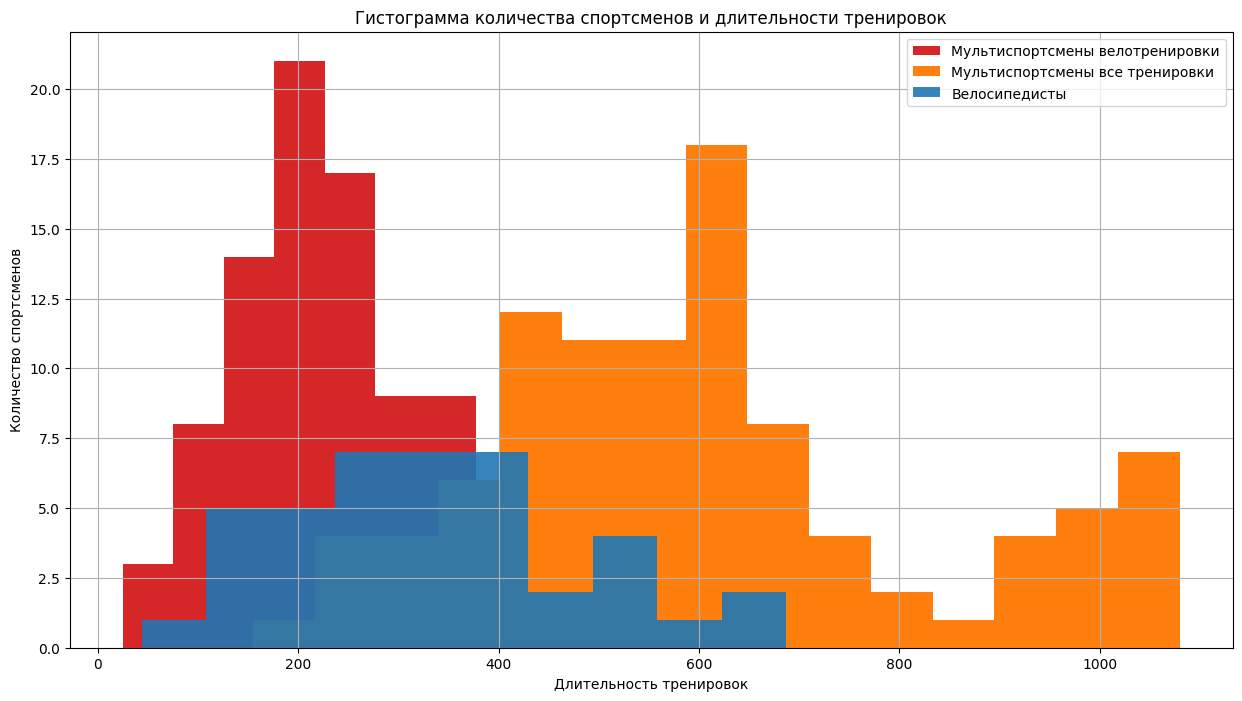

In [449]:
plt.figure(figsize=(15,8))


velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'].hist(bins = 15, alpha = 1, color = 'tab:red', label = 'Мультиспортсмены велотренировки')
velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['all_minute'].hist(bins = 15, alpha = 1,  color = 'tab:orange', label = 'Мультиспортсмены все тренировки')
velo_only.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'].hist(bins = 10, alpha = 0.9, color = 'tab:blue', label = 'Велосипедисты')
plt.title('Гистограмма количества спортсменов и длительности тренировок')
plt.ylabel('Количество спортсменов')
plt.xlabel('Длительность тренировок')
plt.legend()
plt.show()

In [450]:
test_selection(velo_only.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'],
               velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'],
               side='greater',
               h0 = 'Велосипедисты и мультиспортсмены, из "золотой середины" по FTP имеют, одинаковое количество веломинут',
               h1 = 'У велосипедистов, из "золотой середины" по FTP, веломинут больше, чем у мультиспортсменов',
               )

Первая выборка размером 41 прошла проверку на нормальное распределение. pval = 0.541289386347446
Вторая выборка размером 98 НЕ прошла проверку на нормальное распределение. pval = 1.1188506460945993e-05
Дисперсии выборок близки. pval = 0.17718926628041862. Применяем equal_var=True 

Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 0.0017778244981278219
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У велосипедистов, из "золотой середины" по FTP, веломинут больше, чем у мультиспортсменов 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.001792703899276012
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У велосипедистов, из "золотой середины" по FTP, веломинут больше, чем у мультиспортсменов 


In [451]:
test_selection(velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['all_minute'],
               velo_only.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'],
               side='greater',
               h0 = 'Велосипедисты и мультиспортсмены, из "золотой середины" по FTP, имеют одинаковую суммарную длительность всех тренировок',
               h1 = 'У мультиспортсменов, из "золотой середины" по FTP, длительность всех тренировок больше',
               )

Первая выборка размером 98 прошла проверку на нормальное распределение. pval = 0.07204293386371372
Вторая выборка размером 41 прошла проверку на нормальное распределение. pval = 0.541289386347446
Дисперсии выборок близки. pval = 0.06120067251762929. Применяем equal_var=True 

Обе выборки имеют нормальное распределение!
Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 2.3550329308807187e-11
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У мультиспортсменов, из "золотой середины" по FTP, длительность всех тренировок больше 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 5.666260779918921e-11
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У мультиспортсменов, из "золотой середины" по FTP, длительность всех тренировок больше 


То есть у велосипедистов больше именно велотренировок, чем у мультиспортсменов, но у мультиспортсменов больше вообще тренировок, чем у велосипедистов. При этом FTP сопоставимы.


In [452]:
velo_compare.T

,велосипедисты,мультиспортсмены только вело,мультиспортсмены все тренировки
FTP,253.56,250.38,249.87
train_duration,335.54,259.9,603.19


In [453]:
print(f"У велосипедистов велотренировок больше, чем у мультиспортсменов на {round(100 * (velo_compare.loc['велосипедисты', 'train_duration'] - velo_compare.loc['мультиспортсмены только вело', 'train_duration']) / velo_compare.loc['мультиспортсмены только вело', 'train_duration'], 2) } %")
print(f"У мультиспортсменов всех тренировок больше, чем велотренировок у велосипедистов на {round(100 * (velo_compare.loc['мультиспортсмены все тренировки', 'train_duration'] - velo_compare.loc['велосипедисты', 'train_duration']) / velo_compare.loc['велосипедисты', 'train_duration'], 2) } %")
print(f"При этому у велосипедистов FTP больше, чем у мультиспортсменов на {round(100 * (velo_compare.loc['велосипедисты', 'FTP'] - velo_compare.loc['мультиспортсмены все тренировки', 'FTP']) / velo_compare.loc['мультиспортсмены все тренировки', 'FTP'], 2) } %")

У велосипедистов велотренировок больше, чем у мультиспортсменов на 29.1 %
У мультиспортсменов всех тренировок больше, чем велотренировок у велосипедистов на 79.77 %
При этому у велосипедистов FTP больше, чем у мультиспортсменов на 1.48 %


**Промежуточные итоги**

мультиспортсмены с меньшим количеством веломинут не уступают велосипедистам по показателям FTP. Получается, обнаруженная взаимосвязь роста FTP с ростом веломинут ломается. Однако у мультиспортсменов есть и другие тренировки. И тут встает вопрос: это мультиспортсмены более эффективно тренируются именно на вело, или они добирают в других видах тренировок?

# Сравнение способов определения FTP

FTP - это функциональная пороговая мощность или максимальная мощность, которую спортсмен способен проявить при езде на велосипеде в течение 60 минут. Это базовый показатель, на основе которого строятся тренировочные планы. Фактически он задает интенсивность тренровок, поэтому важно точно определить свое текущее FTP.

При этом существует несколько способов определения FTP. Само по себе такое разнообразие подразумевает определенные недостатки в каждом из них.

Поэтому стоит понимать, что в тренировочном процессе завышение FTP значительно хуже занижения. Так как занижениие грозит только тем, что спортсмен не достигнет уровня, который мог бы. А завышение FTP грозит уже непомерной наргузкой, перетренированностью и срывом выполнения всего тренировочного плана.

In [454]:
data['ftp_source_c'] = data['ftp_source'].apply(lambda x: 'Другое' if x not in (
    'По результатом полевых тестирований',
    'Из своих результатах на тренировках',
    'Расчетным путем исходя их результатов гонок',
    'Из результатов лабораторного тестирования',
    ) else x)

In [455]:
data['ftp_source_c'] = data['ftp_source_c'].str.replace('По результатом полевых тестирований', 'Поле')
data['ftp_source_c'] = data['ftp_source_c'].str.replace('Из своих результатах на тренировках', 'Тренировки')
data['ftp_source_c'] = data['ftp_source_c'].str.replace('Расчетным путем исходя их результатов гонок', 'Гонки')
data['ftp_source_c'] = data['ftp_source_c'].str.replace('Из результатов лабораторного тестирования', 'Лаборатория')

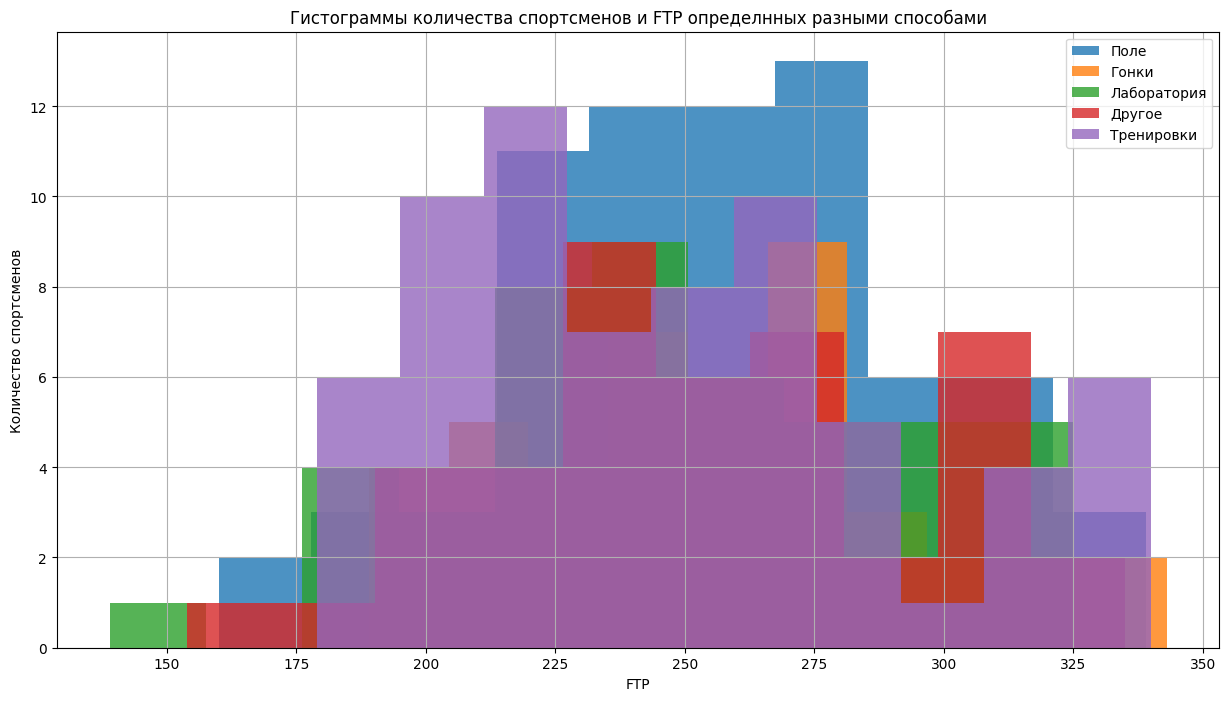

In [456]:
plt.figure(figsize=(15,8))

for ftp_souce in data['ftp_source_c'].unique():
  data.query('ftp_source_c == @ftp_souce')['ftp_c'].hist(bins = 10, alpha = 0.8, label = ftp_souce)

plt.title('Гистограммы количества спортсменов и FTP определнных разными способами')
plt.ylabel('Количество спортсменов')
plt.xlabel('FTP')
plt.legend()
plt.show()

In [457]:
ftp_souce_type = data['ftp_source_c'].unique()
ftp_sourcep_data = dict()
for ftp_source_x in ftp_souce_type:
    ftp_sourcep_data[ftp_source_x] = data.query('ftp_source_c == @ftp_source_x')['ftp_c']
    print(f"{len(ftp_sourcep_data[ftp_source_x])} спортсменов определили свой FTP {ftp_source_x}. Среднее значсение FTP {ftp_sourcep_data[ftp_source_x].median()}")

71 спортсменов определили свой FTP Поле. Среднее значсение FTP 259.0
44 спортсменов определили свой FTP Гонки. Среднее значсение FTP 260.0
46 спортсменов определили свой FTP Лаборатория. Среднее значсение FTP 246.0
43 спортсменов определили свой FTP Другое. Среднее значсение FTP 253.0
69 спортсменов определили свой FTP Тренировки. Среднее значсение FTP 240.0


Проверка на нормальное распределение. В ячейках значения p-value для распределения способа определения FTP.
Подкрашивается ячейка, в которой значение p-value < 0.05, то есть проверка нормального распредения НЕ пройдена.

In [458]:
ftp_sourcep_norm = pd.DataFrame([])
for ftp_source_x in ftp_souce_type:
    pval = stats.normaltest(ftp_sourcep_data[ftp_source_x])[1]
    ftp_sourcep_norm.loc['norm', ftp_source_x] = pval
ftp_sourcep_norm.style.apply(highlight_stat, color='tomato')

,Поле,Гонки,Лаборатория,Другое,Тренировки
norm,0.806984,0.691553,0.879325,0.815952,0.072287


Проверка на равенства дисперсий. В ячейках значения p-value для попарного сравнения дисперсий выборок. Подкрашивается ячейка, в которой значение p-value < 0.05, то есть проверка равенства дисперсий НЕ пройдена.

In [459]:
ftp_souce_leneve = pd.DataFrame([])
for ftp_source_x in ftp_souce_type:
  for ftp_source_y in ftp_souce_type:

        pval = stats.levene(ftp_sourcep_data[ftp_source_x], ftp_sourcep_data[ftp_source_y])[1]

        ftp_souce_leneve.loc[ftp_source_x, ftp_source_y] = pval
ftp_souce_leneve.style.apply(highlight_stat, color='tomato')

,Поле,Гонки,Лаборатория,Другое,Тренировки
Поле,1.000000,0.930885,0.583119,0.752594,0.247613
Гонки,0.930885,1.000000,0.569724,0.716889,0.276005
Лаборатория,0.583119,0.569724,1.000000,0.838341,0.634933
Другое,0.752594,0.716889,0.838341,1.000000,0.489422
Тренировки,0.247613,0.276005,0.634933,0.489422,1.000000


Попарное сравнение выборок FTP, определенного разными способами. В ячейках - p-value нулевой гипотезы, что FTP сопоставимые, альтернативная гипотеза - что FTP, определенное способом по горизонтали больше, чем способом по вертикали.
Подкрашены ячейки, в которых p-value < 0.05 - то есть где нулевая гипотеза отвергается и принимается альтернативная.

Попарная проверка гипотезы, что один из способов определения FTP завышает. Если завышает - подкраситься красным.

In [460]:
ftp_source_table = pd.DataFrame([])
for ftp_source_x in ftp_souce_type:
  for ftp_source_y in ftp_souce_type:
    ftp_source_table.loc[ftp_source_x, ftp_source_y] = stats.ttest_ind(ftp_sourcep_data[ftp_source_x], ftp_sourcep_data[ftp_source_y], alternative = 'greater', equal_var='True')[1]
ftp_source_table.style.apply(highlight_stat, color = 'tomato')

,Поле,Гонки,Лаборатория,Другое,Тренировки
Поле,0.500000,0.500888,0.156130,0.399041,0.105697
Гонки,0.499112,0.500000,0.182551,0.407966,0.138356
Лаборатория,0.843870,0.817449,0.500000,0.743315,0.449539
Другое,0.600959,0.592034,0.256685,0.500000,0.205764
Тренировки,0.894303,0.861644,0.550461,0.794236,0.500000


Определение FTP различными способами не обнаруживают статистически значимое различие результатов.

В связи с этим интересно посмотреть, каким способом спортсмены определяют FTP в зависимости от стажа

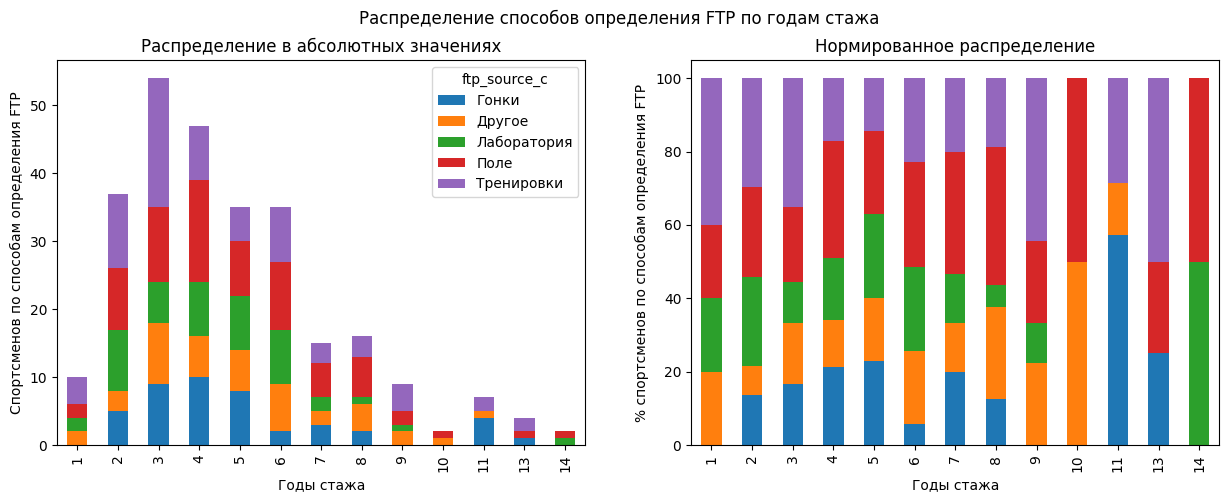

In [461]:
f, ax = plt.subplots(1, 2, figsize=(18,5))

dd = data[['ftp_source_c', 'ftp_c', 'stag_r']].copy()
dd['stag_r'] = round(dd['stag_r'] // 12 + 1)
dd = dd.groupby(['ftp_source_c', 'stag_r'])['ftp_c'].count().reset_index()
dd = dd.pivot_table(index = 'stag_r', columns = 'ftp_source_c', values='ftp_c')
dd = dd.fillna(0)


dd.plot.bar(ax = ax[0], stacked = True, figsize=(15,5))

ax[0].set_title('Распределение в абсолютных значениях')
ax[0].set_xlabel('Годы стажа')
ax[0].set_ylabel('Спортсменов по способам определения FTP')

dd['sum'] = dd.sum(axis=1)
dd = dd.apply(lambda x: 100 * (x / x['sum']), axis=1)
dd = dd.drop(columns = 'sum')

dd.plot.bar(ax = ax[1], stacked = True, figsize=(15,5), legend = None)

ax[1].set_title('Нормированное распределение')
ax[1].set_xlabel('Годы стажа')
ax[1].set_ylabel('% спортсменов по способам определения FTP')


plt.suptitle('Распределение способов определения FTP по годам стажа')
plt.show()

**Промежуточные итоги**

Сравнение способов определения FTP не показало статистически значимое различие между ними

# Изучение аномалий взаимосвязи роста FTP с ростом веломинут

Когортный анализ показал, что FTP с увеличением веломинут по когортам растет не монотонно. Интерпретироавть это можно как неоптимальный объем тренировок. Завышение веломинут, которое не дает прироста FTP, а скорее наоборот. Спортсменам, попавшим в эти локальные минимумы FTP/веломинуты, можно чуть уменьшить объем, и тогда их FTP вырастет.

## Графики взаимосвязей FTP / веломинут

Аппроксимируем данные полиномом высоких степеней

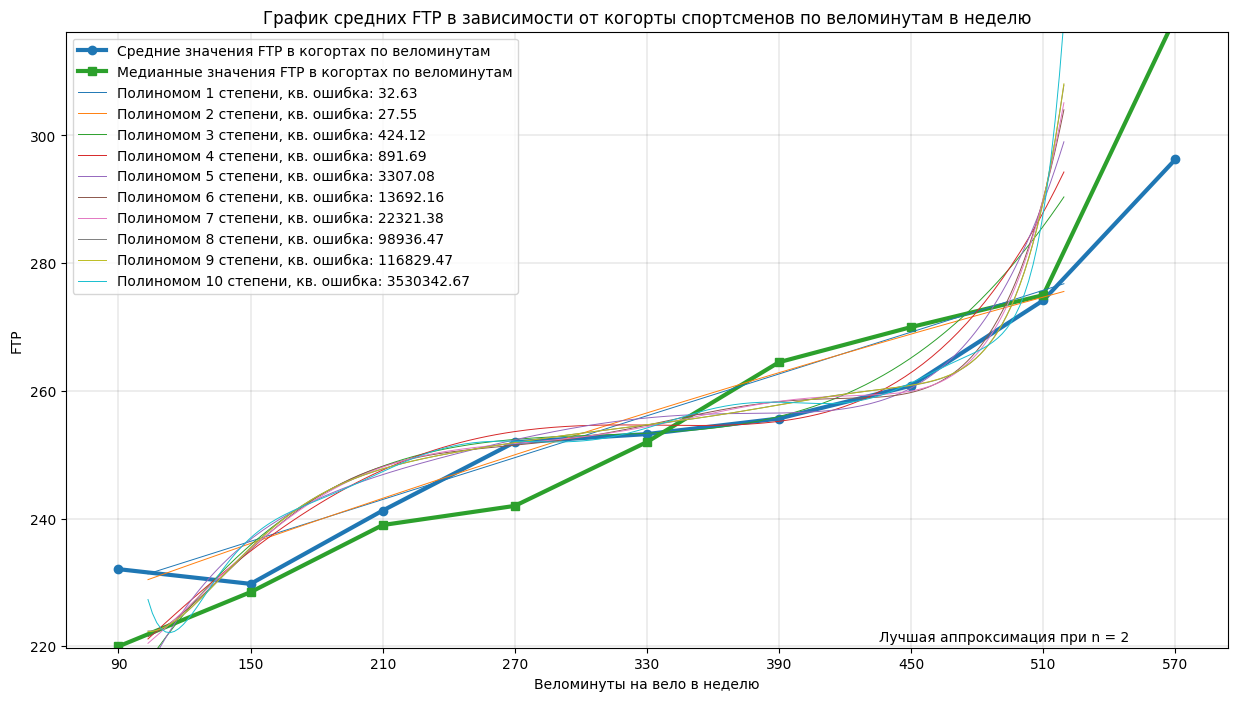

In [462]:
xmin = data['bike_minute'].quantile(0.05)
xmax = data['bike_minute'].quantile(0.90)
sc = data.query('bike_minute > @xmin & bike_minute < @xmax')[['bike_minute', 'ftp_c']].sort_values(by='bike_minute')

fig = plt.figure(figsize = (15, 8))

plt.plot(bikeminut_describe.index[0:-1], bikeminut_describe['mean'][0:-1], linewidth = 3, marker="o", color='tab:blue', label = 'Средние значения FTP в когортах по веломинутам')
plt.plot(bikeminut_describe.index[0:-1], bikeminut_describe['50%'][0:-1], linewidth = 3, marker="s", color='tab:green', label = 'Медианные значения FTP в когортах по веломинутам')

sslast = 99999999999
for i in range(1, 11):
  z = np.polyfit(sc['bike_minute'], sc['ftp_c'], i)
  p = np.poly1d(z)
  ss = 0
  for x in bikeminut_describe.index:
    ss = ss + (p(x) - bikeminut_describe.loc[x, 'mean']) ** 2
    #print(p(x), bikeminut_describe.loc[x, 'mean'])
  if sslast > ss:
     sslast = ss
     bestn = i
  x = np.arange(xmin, xmax, 2)
  plt.plot(x, p(x), linewidth = 0.7 , label = f'Полиномом {i} степени, кв. ошибка: {round(math.sqrt(ss), 2)} ')

plt.title('График средних FTP в зависимости от когорты спортсменов по веломинутам в неделю')

plt.annotate(f'Лучшая аппроксимация при n = {bestn}', xy=(0.7, 0.01), xycoords='axes fraction')
plt.xlabel('Веломинуты на вело в неделю')
plt.ylabel('FTP')
plt.legend()
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.xticks(np.linspace(90, 570, 9))
plt.ylim(bikeminut_describe['mean'].min()-10, bikeminut_describe['mean'].max()+20)
#plt.ylim(0, bikeminut_describe['max'].max())
plt.show()

Различия в средних и медианных значениях говорят несимметричности распределения и/или выбросах. Если встречаются аномально большие для данной когорты значения целевого показателя, то среднее будет выше медианы, и наоборот.

Степень полинома n, при которой получается наилучшая аппроксимация (определяется наименьшей суммой разности квадратов) может указывать на n-1 локальных экстремумов общего тренда исходных данных.

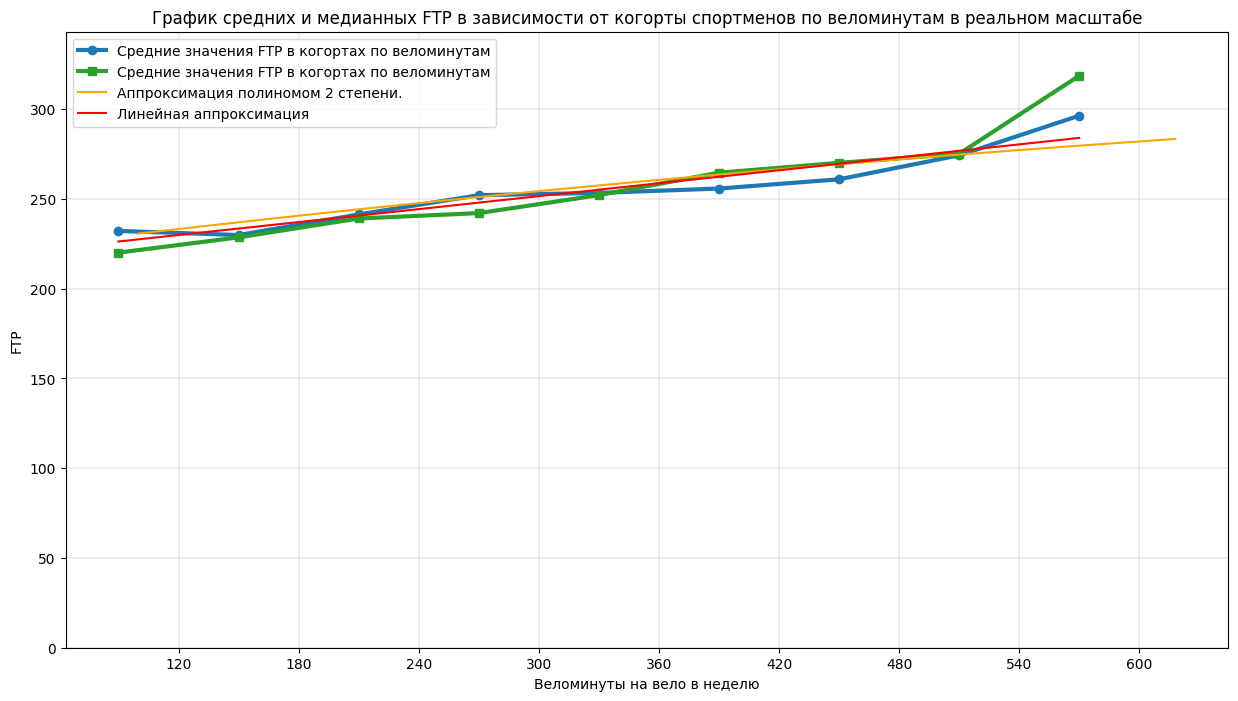

In [463]:
sc = data[['bike_minute', 'ftp_c']].sort_values(by='bike_minute')
xmin = 100
xmax = 620

fig = plt.figure(figsize = (15, 8))
plt.plot(bikeminut_describe.index[0:-1], bikeminut_describe['mean'][0:-1], linewidth = 3, marker="o", color='tab:blue', label = 'Средние значения FTP в когортах по веломинутам')
plt.plot(bikeminut_describe.index[0:-1], bikeminut_describe['50%'][0:-1], linewidth = 3, marker="s", color='tab:green', label = 'Средние значения FTP в когортах по веломинутам')

z = np.polyfit(sc['bike_minute'], sc['ftp_c'], bestn)
p = np.poly1d(z)
x = np.arange(xmin, xmax, 2)

plt.plot(x, p(x), color='orange', label = f'Аппроксимация полиномом {bestn} степени.')

z = np.polyfit(bikeminut_describe.index[0:-1], bikeminut_describe['mean'][0:-1], 1)
p = np.poly1d(z)
plt.plot(bikeminut_describe.index[0:-1], p(bikeminut_describe.index[0:-1]), color='red', label = 'Линейная аппроксимация')

plt.title('График средних и медианных FTP в зависимости от когорты спортменов по веломинутам в реальном масштабе')
plt.xlabel('Веломинуты на вело в неделю')
plt.ylabel('FTP')
plt.legend()
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.xticks(np.linspace(120, 600, 9))
plt.ylim(0, bikeminut_describe['max'].max())
plt.show()

## Графики взаимосвязей веломинут / FTP

Аппроксимируем данные полиномами высоких степеней

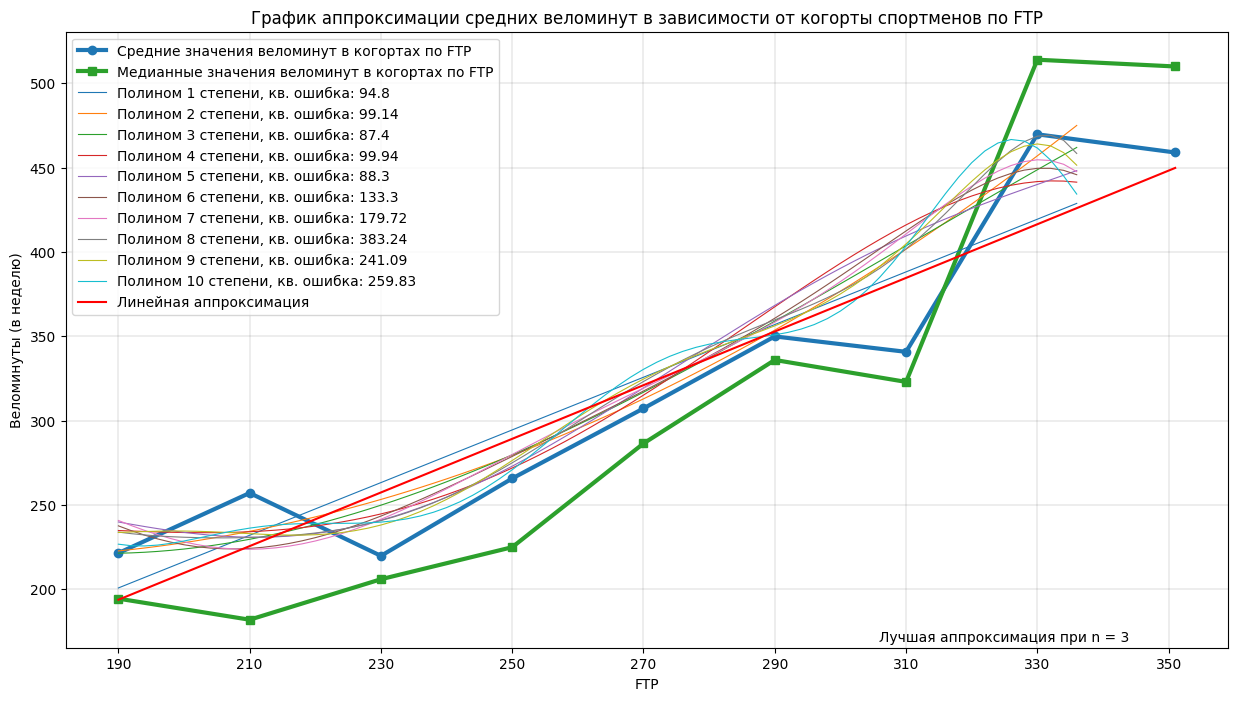

In [464]:
sc = data[['ftp_c', 'bike_minute']].sort_values(by='ftp_c')
xmin = data['ftp_c'].quantile(0.05)
xmax = data['ftp_c'].quantile(0.99)
#xmin = data['ftp_c'].min()
#xmax = data['ftp_c'].max()


fig = plt.figure(figsize = (15, 8))
plt.plot(ftp_describe.index, ftp_describe['mean'], linewidth = 3, marker="o", color='tab:blue', label = 'Средние значения веломинут в когортах по FTP')
plt.plot(ftp_describe.index, ftp_describe['50%'], linewidth = 3, marker="s", color='tab:green', label = 'Медианные значения веломинут в когортах по FTP')

sslast = 99999999999
for i in range(1, 11):
  z = np.polyfit(sc['ftp_c'], sc['bike_minute'], i)
  p = np.poly1d(z)
  ss = 0
  for x in ftp_describe.index:
    ss = ss + (p(x) - ftp_describe.loc[x, 'mean']) ** 2
    #print(p(x), ftp_describe.loc[x, 'mean'])
  if sslast > ss:
     sslast = ss
     bestn = i
  x = np.arange(xmin, xmax, 2)
  plt.plot(x, p(x), linewidth = 0.8, label = f'Полином {i} степени, кв. ошибка: {round(math.sqrt(ss), 2)} ')

z = np.polyfit(ftp_describe.index, ftp_describe['mean'], 1)
p = np.poly1d(z)
plt.plot(ftp_describe.index, p(ftp_describe.index), color='red', label = 'Линейная аппроксимация')

plt.annotate(f'Лучшая аппроксимация при n = {bestn}', xy=(0.7, 0.01), xycoords='axes fraction')
plt.title('График аппроксимации средних веломинут в зависимости от когорты спортменов по FTP')
plt.xlabel('FTP')
plt.ylabel('Веломинуты (в неделю)')
plt.legend()
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.xticks(np.linspace(190, 350, 9))
#plt.ylim(0, bikeminut_describe['max'].max())
plt.show()

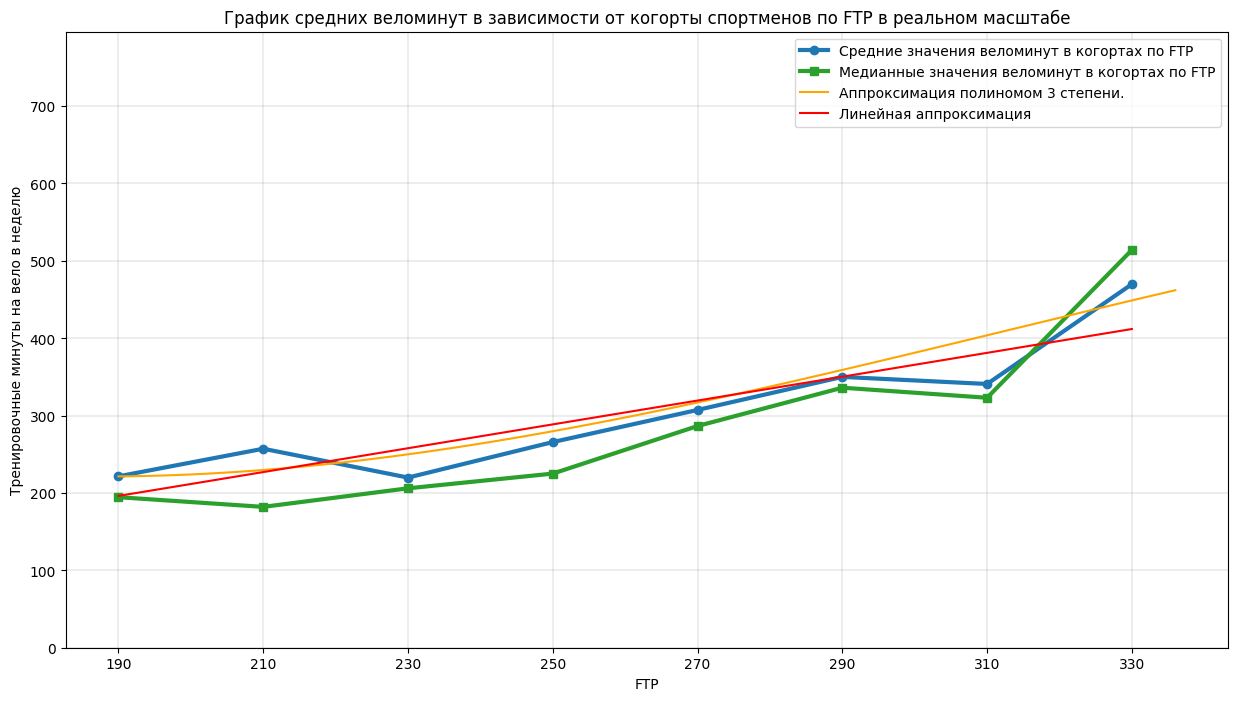

In [465]:
sc = data[['ftp_c', 'bike_minute']].sort_values(by='ftp_c')
xmin = data['ftp_c'].quantile(0.05)
xmax = data['ftp_c'].quantile(0.99)
#xmin = data['ftp_c'].min()
#xmax = data['ftp_c'].max()


fig = plt.figure(figsize = (15, 8))
plt.plot(ftp_describe.index[0:-1], ftp_describe['mean'][0:-1], linewidth = 3, marker="o", color='tab:blue', label = 'Средние значения веломинут в когортах по FTP')
plt.plot(ftp_describe.index[0:-1], ftp_describe['50%'][0:-1], linewidth = 3, marker="s", color='tab:green', label = 'Медианные значения веломинут в когортах по FTP')

z = np.polyfit(sc['ftp_c'], sc['bike_minute'], bestn)
p = np.poly1d(z)
x = np.arange(xmin, xmax, 2)
plt.plot(x, p(x), color='orange', label = f'Аппроксимация полиномом {bestn} степени.')

z = np.polyfit(ftp_describe.index[0:-1], ftp_describe['mean'][0:-1], 1)
p = np.poly1d(z)
plt.plot(ftp_describe.index[0:-1], p(ftp_describe.index[0:-1]), color='red', label = 'Линейная аппроксимация')

plt.title('График средних веломинут в зависимости от когорты спортменов по FTP в реальном масштабе')
plt.xlabel('FTP')
plt.ylabel('Тренировочные минуты на вело в неделю')
plt.legend()
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.xticks(np.linspace(190, 330, 8))
plt.ylim(0, ftp_describe['max'].max())
plt.show()

Различия в средних и медианных значениях особенно заметны на графике веломинуты / FTP для когорты FTP210.

## Гипотезы

Поиск причин немонотонности роста FTP с ростом веломинут можно свести к поиску различий в когортах

**Гипотеза: эффект связан с различной долей велосипедистов в когортах**. Велосипедисты, как было показано выше, имеют больше веломинут. Следовтельно, если в когорту велосипедистов попало значимо больше, чем в соседние, то в этой когорте будет и больше веломинут.

Распределение видов спорта по когортам FTP

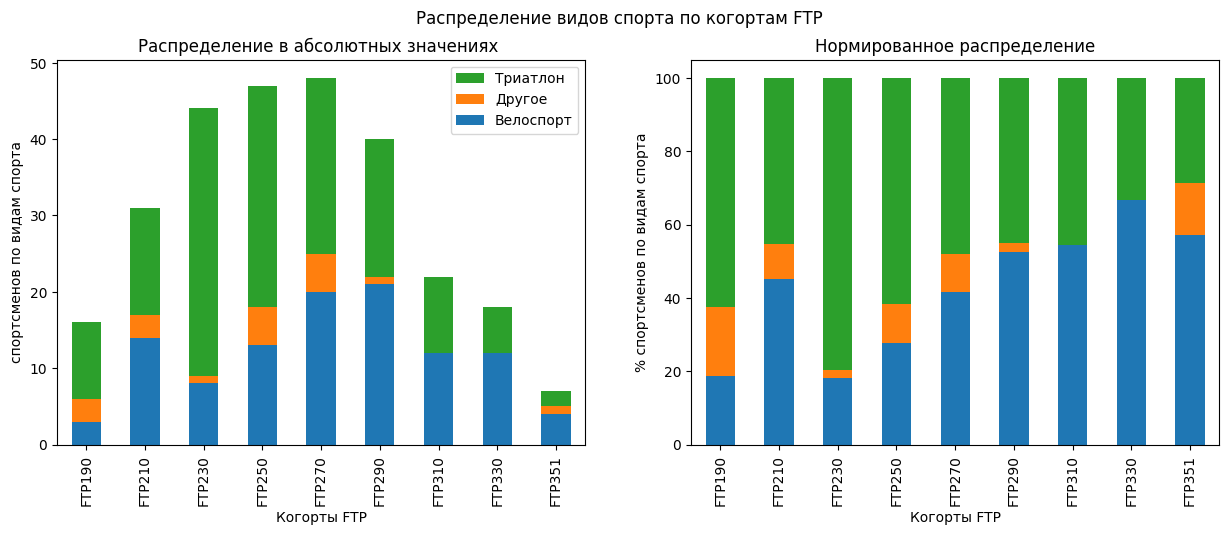

In [466]:
f, ax = plt.subplots(1, 2, figsize=(18,5))
ftp_sport = data.groupby(['ch_ftp', 'sport_c'])['sport'].count()
ftp_sport = ftp_sport.reset_index()
ftp_sport = ftp_sport.pivot_table(index = 'ch_ftp', columns = 'sport_c', values = 'sport')
ftp_sport = ftp_sport.fillna(0)

ftp_sport.plot.bar(ax = ax[0], stacked = True, figsize=(15,5))

ax[0].set_title('Распределение в абсолютных значениях ')
ax[0].set_xlabel('Когорты FTP')
ax[0].set_ylabel('спортсменов по видам спорта')
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(reversed(handles), reversed(labels))

ftp_sport['sum'] = ftp_sport.sum(axis=1)
dd = ftp_sport.apply(lambda x: 100 * (x / x['sum']), axis=1)
dd = dd.drop(columns = 'sum')
dd.plot.bar(ax = ax[1], stacked = True, figsize=(15,5), legend = None)
ax[1].set_title('Нормированное распределение')
ax[1].set_xlabel('Когорты FTP')
ax[1].set_ylabel('% спортсменов по видам спорта')

plt.suptitle('Распределение видов спорта по когортам FTP')
plt.show()

Попарное сравнение доли велосипедистов в когортах. Для сравнения применяется Z-test пропорций. В ячейках - p-value нулевой гипотезы H0, что пропорции велосипедистов из когорты FTP по вертикали и когорты по горизонтали - равны, альтернативная гипотеза H1 - что в когорте FTP по вертикали доля велосипедистов БОЛЬШЕ. Подкрашены ячейки, в которых p-value < 0.05 - то есть где нулевая гипотеза отвергается и принимается альтернативная.


In [467]:
ftp_sport_pval = pd.DataFrame([])
for ff1 in ftp_sport.index:
  for ff2 in ftp_sport.index:
    ftp_sport_pval.loc[ff1, ff2] = z_krit(ftp_sport.loc[ff1, 'Велоспорт'], ftp_sport.loc[ff2, 'Велоспорт'], ftp_sport.loc[ff1, 'sum'],  ftp_sport.loc[ff2, 'sum'], alt = 'larger')
ftp_sport_pval.style.apply(highlight_stat, color='orange')

,FTP190,FTP210,FTP230,FTP250,FTP270,FTP290,FTP310,FTP330,FTP351
FTP190,1.000000,1.000000,0.959885,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
FTP210,0.074157,1.000000,0.011501,0.111840,0.759364,1.000000,1.000000,1.000000,1.000000
FTP230,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
FTP250,0.479457,1.000000,0.283556,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
FTP270,0.098026,1.000000,0.014467,0.151688,1.000000,1.000000,1.000000,1.000000,1.000000
FTP290,0.021135,0.539583,0.000953,0.017954,0.310388,1.000000,1.000000,1.000000,1.000000
FTP310,0.025824,0.500709,0.002443,0.030367,0.315317,0.877260,1.000000,1.000000,1.000000
FTP330,0.004975,0.145903,0.000210,0.003821,0.070311,0.313499,0.436275,1.000000,0.656005
FTP351,0.065584,0.566350,0.023996,0.117135,0.440524,0.820340,0.904201,1.000000,1.000000


Для подсвеченной ячейки читается так: в когорте по вертикали больше велосипедистов, чем в когорде по горизонтали.
То есть в когорте FTP210 статистически значимо больше велосипедистов, чем в когорте FTP230. А велосипедисты, как было показано выше, имеют больше веломинут.

**Гипотеза: эффект связан с тренировочным стажем**. То есть в когорте ftp210 менее опытные спортсмены, которые и завышают свои веломинуты.


Тепловая карта FTP / стажа

In [468]:
dd = data.groupby(['ch_ftp', 'ch_st'])['sport'].count()
dd = dd.reset_index()
dd = dd.pivot_table(index = 'ch_st', columns = 'ch_ftp', values = 'sport')
dd = dd.fillna(0)
dd[::-1].style.apply(background_gradient_alltable, cmap='RdYlGn_r', m=dd.min().min(), M=dd.max().max(), low=0, high=0.1).format(precision=0)
#dd.style.background_gradient(cmap ='RdYlGn_r').format(precision=0)

ch_ftp,FTP190,FTP210,FTP230,FTP250,FTP270,FTP290,FTP310,FTP330,FTP351
ch_st,,,,,,,,,
стаж158,0,2,5,2,5,6,1,3,0
стаж090,1,1,4,5,1,1,1,1,1
стаж078,1,1,1,1,5,3,1,2,0
стаж066,1,1,6,6,9,3,4,3,2
стаж054,3,3,0,4,7,7,6,4,1
стаж042,1,2,10,10,6,9,5,3,2
стаж030,5,13,10,11,5,8,3,0,1
стаж018,4,8,8,8,10,3,1,2,0


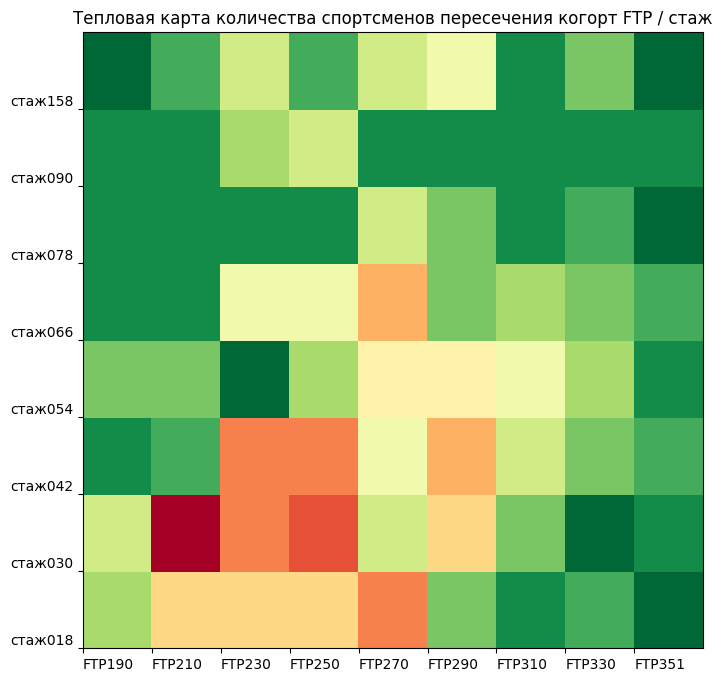

In [469]:
fig = plt.figure(figsize = (8, 8))
plt.pcolor(dd, cmap ='RdYlGn_r')
plt.xticks(range(len(dd.columns)), dd.columns, ha='left', va='top')
plt.yticks(range(len(dd.index)), dd.index, ha='right', va='bottom')
plt.title('Тепловая карта количества спортсменов пересечения когорт FTP / стаж')
plt.show()

Распределение представителей когорт стажа по когортам FTP

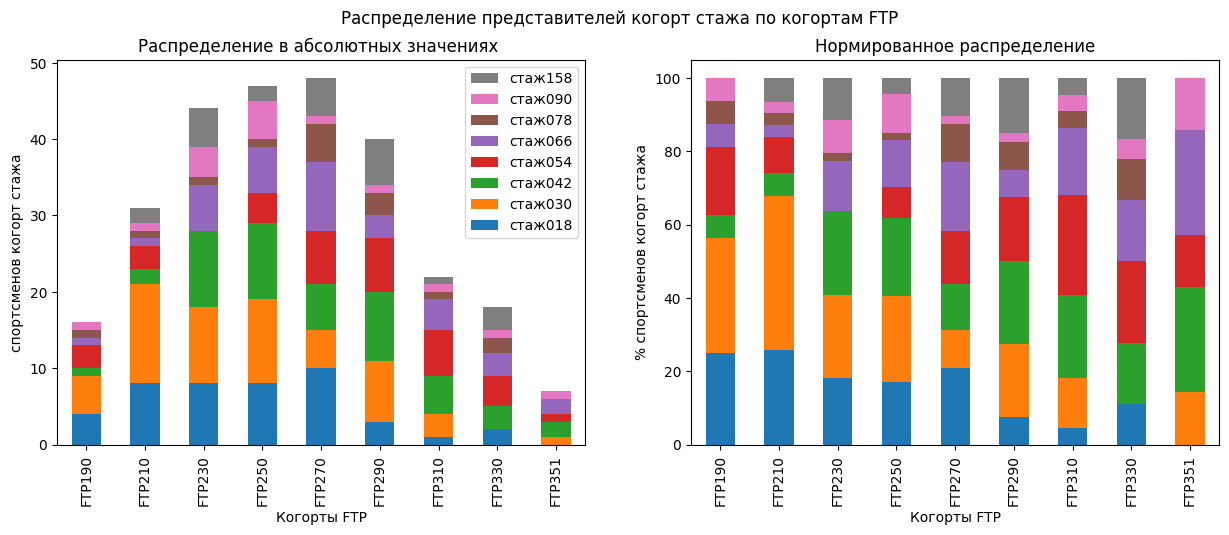

In [470]:
f, ax = plt.subplots(1, 2, figsize=(18,5))

dd = data.groupby(['ch_ftp', 'ch_st'])['sport'].count()
dd = dd.reset_index()
dd = dd.pivot_table(index = 'ch_ftp', columns = 'ch_st', values = 'sport')
dd = dd.fillna(0)

dd.plot.bar(ax = ax[0], stacked = True, figsize=(15,5))

ax[0].set_title('Распределение в абсолютных значениях ')
ax[0].set_xlabel('Когорты FTP')
ax[0].set_ylabel('спортсменов когорт стажа')
#ax[0].legend(reversed(labels))
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(reversed(handles), reversed(labels))

dd['sum'] = dd.sum(axis=1)
dd = dd.apply(lambda x: 100 * (x / x['sum']), axis=1)
dd = dd.drop(columns = 'sum')

dd.plot.bar(ax = ax[1], stacked = True, figsize=(15,5), legend = None)

ax[1].set_title('Нормированное распределение')
ax[1].set_xlabel('Когорты FTP')
ax[1].set_ylabel('% спортсменов когорт стажа')


plt.suptitle('Распределение представителей когорт стажа по когортам FTP')
plt.show()

На графиках более высокие секции - более опытные спортсмены. Соответственно, если в когорте более высокие секции "шире в высоту", то это означает, что там больше опытных спортсменов. И на оборот, если более широкие нижние секции - в этой когорте больше малоопытных спортсменов. Как видно из графиков, в когорте ftp210 больше малоопытных спортсменов.

Сравним попарно стаж в когортах статистическими тестами

Проверка на нормальное распределение. В ячейках значения p-value для распределения способа определения FTP. Подкрашивается ячейка, в которой значение p-value < 0.05, то есть проверка нормального распределения НЕ пройдена.


In [471]:
ftp_box_norm = pd.DataFrame([])
for ff1 in ftpbox:
    #print(ff1)
    if len(ftpbox[ff1]) < 8 : continue
    pval = stats.normaltest(ftpbox[ff1]['stag_r'])[1]
    ftp_box_norm.loc['norm', ff1] = pval
ftp_box_norm.style.apply(highlight_stat, color='tomato')

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  res = hypotest_fun_out(*samples, **kwds)


,190,210,230,250,270,290,310,330
norm,0.322454,0.003160,0.000875,0.025845,0.006703,0.001863,0.002677,0.075535


Проверка на равенства дисперсий. В ячейках значения p-value для попарного сравнения дисперсий выборок. Подкрашивается ячейка, в которой значение p-value < 0.05, то есть проверка равенства дисперсий НЕ пройдена.

In [472]:
ftp_box_leneve = pd.DataFrame([])
for ff1 in ftpbox:
  for ff2 in ftpbox:

        pval = stats.levene(ftpbox[ff1]['stag_r'], ftpbox[ff2]['stag_r'])[1]

        ftp_box_leneve.loc[ff1, ff2] = pval
ftp_box_leneve.style.apply(highlight_stat, color='tomato')

,190,210,230,250,270,290,310,330,351
190,1.000000,0.813825,0.273840,0.624713,0.275800,0.256813,0.781558,0.364029,0.781430
210,0.813825,1.000000,0.111284,0.384137,0.118336,0.104654,0.992312,0.243224,0.958360
230,0.273840,0.111284,1.000000,0.250078,0.658423,0.974123,0.139235,0.785304,0.353734
250,0.624713,0.384137,0.250078,1.000000,0.374403,0.234924,0.382398,0.496374,0.536963
270,0.275800,0.118336,0.658423,0.374403,1.000000,0.631796,0.125997,0.972312,0.307617
290,0.256813,0.104654,0.974123,0.234924,0.631796,1.000000,0.128079,0.763696,0.336109
310,0.781558,0.992312,0.139235,0.382398,0.125997,0.128079,1.000000,0.217823,0.954314
330,0.364029,0.243224,0.785304,0.496374,0.972312,0.763696,0.217823,1.000000,0.372095
351,0.781430,0.958360,0.353734,0.536963,0.307617,0.336109,0.954314,0.372095,1.000000


Используется тест Мана-Утни, так как выборки получаются небольшие и не проходят проверку на нормальное распределение.

В ячейках - p-value нулевой гипотезы H0, что стаж спортсменов из когорты FTP по вертикали такой же как из когорты по горизонтали, альтернативная гипотеза H1 - что стаж МЕНЬШЕ.
Подкрашены ячейки, в которых p-value < 0.05 - то есть где нулевая гипотеза отвергается и принимается альтернативная.

In [473]:
ftp_box_pval = pd.DataFrame([])
for ff1 in ftpbox:
  for ff2 in ftpbox:
    #ftp_box_pval.loc[ff1, ff2] = stats.ttest_ind(ftpbox[ff1]['stag_r'], ftpbox[ff2]['stag_r'], alternative = 'less', equal_var='True')[1]
    ftp_box_pval.loc[ff1, ff2] = stats.mannwhitneyu(ftpbox[ff1]['stag_r'], ftpbox[ff2]['stag_r'], alternative = 'less')[1]
ftp_box_pval.style.apply(highlight_stat, color='lime')

,190,210,230,250,270,290,310,330,351
190,0.507607,0.765040,0.195847,0.241749,0.071348,0.065705,0.034325,0.013710,0.073602
210,0.242067,0.502899,0.023797,0.032676,0.005307,0.003185,0.001643,0.001273,0.017928
230,0.808762,0.976805,0.501675,0.594831,0.242223,0.181224,0.127910,0.041768,0.200144
250,0.763193,0.968073,0.408273,0.501523,0.128968,0.130168,0.075531,0.018672,0.152032
270,0.930752,0.994845,0.760224,0.872601,0.501472,0.506730,0.424173,0.144947,0.394649
290,0.936601,0.996926,0.821143,0.871642,0.496635,0.501940,0.325084,0.109332,0.352801
310,0.967884,0.998451,0.874932,0.926301,0.580815,0.680250,0.504745,0.141780,0.438361
330,0.987462,0.998812,0.959605,0.981992,0.858332,0.893811,0.864302,0.506384,0.768902
351,0.935353,0.983703,0.807490,0.854008,0.615113,0.658360,0.581931,0.250167,0.526138


В результате сравнения выборок: у спортсменов из когорты FTP 210 ватт в сравнении с спортсменами из когорт 230-999 нулевая гипотеза отвергается в пользу альтернативной.
То есть у спортсменов из когорты 210 ватт статистически достоверно меньше стажа, чем в когорте 230.

Также есть **гипотеза, что это просто методическая погрешность**, связанная с неудачным делением на когорты, или тем, что в опросе частью спортсменов указываются целое количество часов "на глаз и примерно". Другие же указали данные из какого-либо сервиса анализа своих тренировок с точностью до секунд.

**Промежуточный итог**

Взаимосвязь роста FTP и веломинут имеет не монотонный характер. Это может быть связано как с неравномерным распределеним спортсменов по видам спорта в когорты, так и со стажем спортсменов. Так мультиспортсмены, у которых только велотренировки, имеют больше веломинут. С другой стороны, менее опытные спортсмены проводят слишком объемные велотренировки.

# Выводы

Исследование взаимосвязи функциональной мощности и длительности тренировок по данным опроса 290 велосипедистов и триатлетов привело к следующим выводам:

- Между FTP и длительностью велотренировок у велосипедистов и триатлетов в целом обнаруживается средняя положительная корреляция. Спортсмены, которые тренируются в неделю на один час больше, имеют и FTP в среднем на 6-7 ватт больше.

- Когортный анализ показывает взаимосвязь роста веломинут и FTP. Однако. когортный анализ дает понимание, что не прямая зависимость или строгий закон. Спортсмены с определенным объемом веломинут могут войти в разные когорты по FTP.

- Взаимосвязи с тренировочным стажем также обнаруживаются при когортной анализе. Она имеет нелинейный характер и показывает выход на максимальные значения FTP на 3-6 годы стажа, а также стабилизацию объема веломинут на уровне 200-400 минут.

- Сравнение спортсменов только с велотренировками и сочетающих их с другими активностями показало, что они имеют сопоставимые FTP. Однако при этом длительность велотренировок у "чистых" велосипедистов на треть большее. Скорее всего, спортсмены занимающиеся несколькими видами спорта дорабатывают свою форму тренировками по другим видам спорта. С учетом всех тренировок, перевес в длительности занятий уже у мультиспортивных атлетов, более чем в полтора раза.

- Сравнение способов определения FTP не показало статистически значимое различие между ними.

- Взаимосвязь роста FTP и длительности тренировок - не монотонная. Вероятно, это связно с завышением некоторыми спортсменами длительности своих велотренировок. Возможно, это просто методическая ошибка.